### Change log

#### 1. Observe the feat distribution via t-SNE 
#### 2. Re-sampling the unbalanced data to balance via over-sampling and SMOTE
#### 3. Replace the previous R0 (3 categories) with the numerical R0 value.
* Change the negative value to the mean of the other positive values

#### 4. Train/evaluate the models using the unbalanced and balanced data.
#### 5. Adjus the monitor metrics from f1_weight to original loss
* TBD: Select the most suitable evaluation metrics as the cross-validation monitor_metrics

#### 6 Compare the softmax output (ie the probability of each dynamic sums to one) vs the independent probability (the probability of a dynamic is independent from the other and doesn’t sum up to one, it can be even 1 for all).
#### 7. Save the models and analyze the mis-classification of the growing clusters, ie which are wrongly assigned to stable or decaying.
* Visualize via the confusion matrix

#### 8. Analysis the classification result via the HiPlot
#### 9. Convert the codes to the module format

### Load the train/test

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline

ds_name = '02172021'
split_rs = '123'
ds_folder = f'../data/{ds_name}/split_rs{split_rs}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/02172021/split_rs123/test.csv
../data/02172021/split_rs123/train.csv
../data/02172021/split_rs123/test_edge.csv
../data/02172021/split_rs123/train_edge.csv


In [2]:
#Import the files
train_df = pd.read_csv(f'{ds_folder}/train.csv')
test_df = pd.read_csv(f'{ds_folder}/test.csv')

/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,3,4,16,19,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
test_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm
118163,Background,893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118164,Background,893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118165,Background,893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118166,Background,893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118167,Background,893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Remove the background nodes

In [4]:
train_df = train_df[train_df['cluster_id'] != 'Background']
test_df = test_df[test_df['cluster_id'] != 'Background']
print(f'Train: {train_df.shape}\nTest: {test_df.shape}')

Train: (74396, 47)
Test: (18628, 47)


In [5]:
test_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm
18623,c7,893,E,static,stable,0.882798,12.0,5.0,0.531162,5.068966,...,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886
18624,c7,893,E,static,stable,0.882798,12.0,5.0,0.531162,5.068966,...,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886
18625,c7,893,E,static,stable,0.882798,12.0,5.0,0.531162,5.068966,...,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886
18626,c7,893,E,static,stable,0.882798,12.0,5.0,0.531162,5.068966,...,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886
18627,c7,893,E,static,stable,0.882798,12.0,5.0,0.531162,5.068966,...,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886


### Load the feature desciption

In [6]:
import json
js_f = osp.join('../aly/feat_dict.json')

with open(js_f, 'r') as f:
    feat_desc = json.load(f)

input_feat = feat_desc['norm_onehot_feats']
print(f'Inputs: {len(input_feat)}, {input_feat}')
label_feat = 'dynamic_cat'

label_map = feat_desc['dynamic']
label_map = {int(k): v for k, v in label_map.items()}
print(label_map)

Inputs: 21, ['v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm', 'oster-norm', 'birth_rate-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'R0_cat_0', 'R0_cat_1', 'R0_cat_2', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']
{0: 'decay', 1: 'growth', 2: 'static'}


#### Replace the previous R0 (3 categories) with the normalized numerical R0 value.

In [7]:
rm_r0_cols = set(['R0_cat_0', 'R0_cat_1', 'R0_cat_2'])
input_feat = [feat for feat in input_feat if feat not in rm_r0_cols]
print(len(input_feat), input_feat)

18 ['v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm', 'oster-norm', 'birth_rate-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']


#### Remove the negative R0 and normalize it
* Use the mean value of positive R0 in the **training** to replace all the negative R0 in the training and test
* Normalize the R0 

In [8]:
from sklearn import preprocessing

train_raw_r0 = np.reshape(train_df['R0'].values, (-1, 1))
test_raw_r0 = np.reshape(test_df['R0'].values, (-1, 1))

# negtive replacement for train
train_r0_neg_idx = train_raw_r0 <= 0
train_r0_pos_idx = train_raw_r0 > 0
avg_train_r0 = np.average(train_raw_r0[train_r0_pos_idx])

train_raw_r0[train_r0_neg_idx] = avg_train_r0

# neg replacement for test
test_r0_neg_idx = test_raw_r0 <= 0
test_raw_r0[test_r0_neg_idx] = avg_train_r0

In [9]:
train_df['R0'].describe()

count    74396.000000
mean         1.774971
std          0.847471
min          0.000216
25%          1.440777
50%          1.774971
75%          1.890583
max          6.709768
Name: R0, dtype: float64

In [10]:
# Standardization non-category features
r0_norm_col = 'R0-norm'
std_scaler = preprocessing.StandardScaler().fit(train_raw_r0)
norm_train_vals = std_scaler.transform(train_raw_r0)

norm_train_node_df = pd.DataFrame(norm_train_vals, columns=[r0_norm_col], index=train_df.index)
train_df = pd.concat([train_df, norm_train_node_df], axis=1)

train_df[r0_norm_col].describe()

count    7.439600e+04
mean     5.195646e-16
std      1.000007e+00
min     -2.094191e+00
25%     -3.943451e-01
50%      5.240204e-16
75%      1.364208e-01
max      5.823007e+00
Name: R0-norm, dtype: float64

In [11]:
norm_test_vals = std_scaler.transform(test_raw_r0)
norm_test_df = pd.DataFrame(norm_test_vals, columns=[r0_norm_col], index=test_df.index)
test_df = pd.concat([test_df, norm_test_df], axis=1)

test_df[r0_norm_col].describe()

count    1.862800e+04
mean     4.001491e-02
std      1.115532e+00
min     -2.088109e+00
25%     -5.447101e-01
50%      5.240204e-16
75%      2.816876e-01
max      5.412595e+00
Name: R0-norm, dtype: float64

In [12]:
input_feat += [r0_norm_col]

In [13]:
x_train = train_df[input_feat]
y_train = train_df[label_feat]
treeid_train = train_df['sim']

x_test = test_df[input_feat]
y_test = test_df[label_feat]
treeid_test = test_df['sim']

array([[<AxesSubplot:title={'center':'v_sampling_fraction-norm'}>,
        <AxesSubplot:title={'center':'v_cluster_size-norm'}>,
        <AxesSubplot:title={'center':'v_timespan-norm'}>,
        <AxesSubplot:title={'center':'oster-norm'}>],
       [<AxesSubplot:title={'center':'birth_rate-norm'}>,
        <AxesSubplot:title={'center':'PD-norm'}>,
        <AxesSubplot:title={'center':'abs_growth_rate-norm'}>,
        <AxesSubplot:title={'center':'fraction_time_growth-norm'}>],
       [<AxesSubplot:title={'center':'r_max-norm'}>,
        <AxesSubplot:title={'center':'cherries-norm'}>,
        <AxesSubplot:title={'center':'ltt_shape_cat_0'}>,
        <AxesSubplot:title={'center':'ltt_shape_cat_1'}>],
       [<AxesSubplot:title={'center':'ltt_shape_cat_2'}>,
        <AxesSubplot:title={'center':'ltt_shape_cat_3'}>,
        <AxesSubplot:title={'center':'gamma_cat_0'}>,
        <AxesSubplot:title={'center':'gamma_cat_1'}>],
       [<AxesSubplot:title={'center':'gamma_cat_2'}>,
        <AxesS

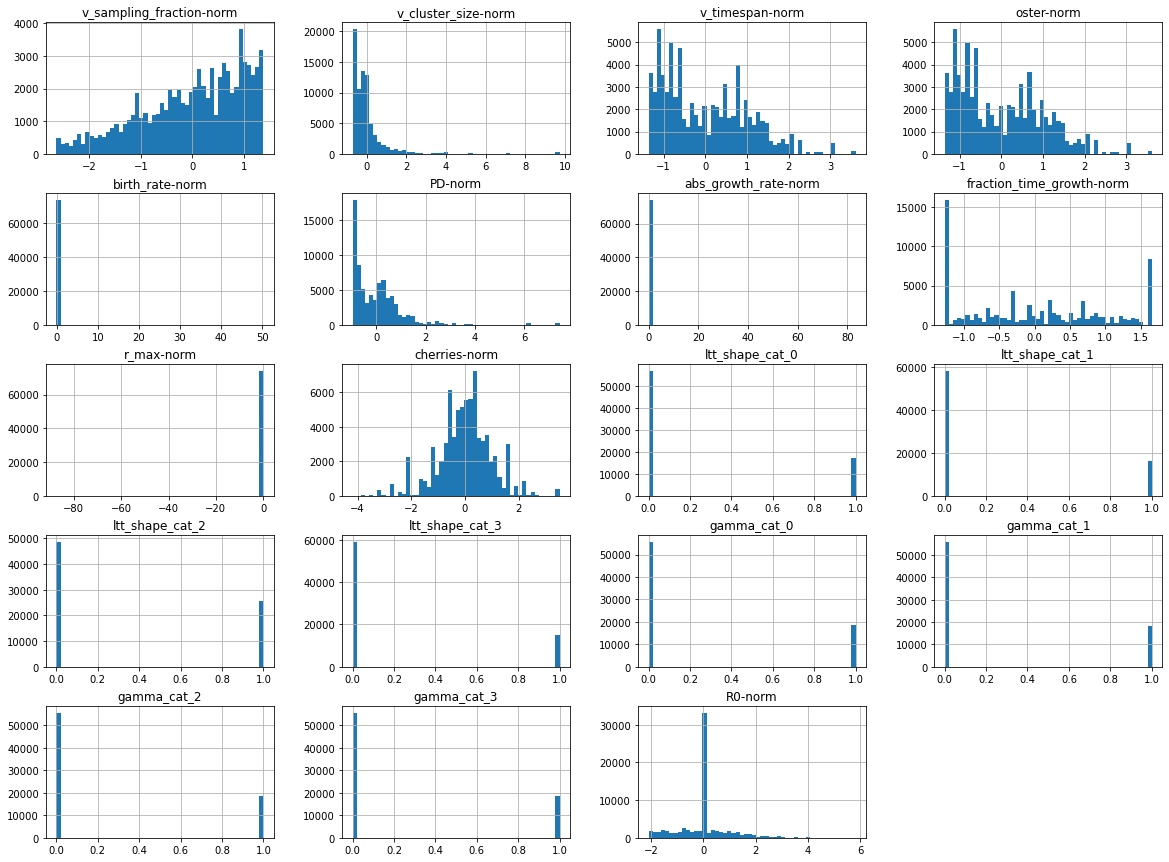

In [14]:
x_train.hist(bins=50,figsize=(20,15))

### Label distribution

Train:
static    73.037529
decay     17.572181
growth     9.390290
Name: dynamic, dtype: float64

Test:
static    73.062057
decay     16.378570
growth    10.559373
Name: dynamic, dtype: float64



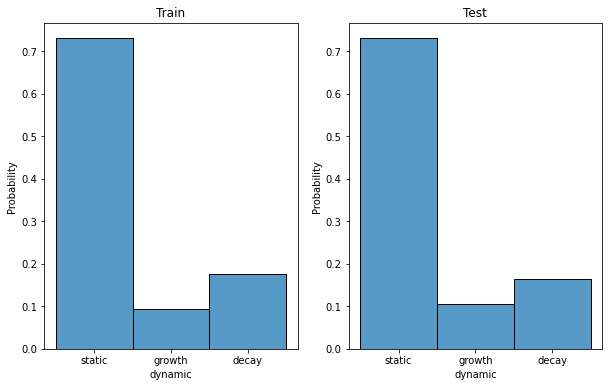

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

for i, (title, label_df) in enumerate(zip(['Train', 'Test'], [train_df['dynamic'], test_df['dynamic']])): 
    sns.histplot(label_df, bins='auto', stat="probability", ax=axs[i])
    axs[i].set_title(title)
    print(f'{title}:\n{label_df.value_counts(normalize=True) * 100}\n')

In [16]:
y_test.head()

0    2.0
1    2.0
2    2.0
3    2.0
4    2.0
Name: dynamic_cat, dtype: float64

### SMOTE and RandomOverSampler for resampling the imbalanced data

#### Get the cat features which is used for SMOTENC

In [17]:
import re

col_names = list(x_train.columns)
cat_patterns = ['ltt_shape_cat_\d*', 'gamma_cat_\d']
cat_cols_ids = []

for pattern in cat_patterns:
    for col in col_names:
        m = re.match(pattern, col)
        if m:
            idx = col_names.index(m.group(0))
            cat_cols_ids.append(idx)
            print(col_names[idx])

ltt_shape_cat_0
ltt_shape_cat_1
ltt_shape_cat_2
ltt_shape_cat_3
gamma_cat_0
gamma_cat_1
gamma_cat_2
gamma_cat_3


In [18]:
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from collections import Counter
np.random.seed(0)

train_data_dict = dict()
treeid_col_idx = x_train.shape[1]  # Add the sim col to the end of the trian_df
cat_cols_ids += [treeid_col_idx]

sampler_dict = {
    'org': None,
    'ros': RandomOverSampler(random_state=0, shrinkage=0.1), 
    'smotenc': SMOTENC(categorical_features=cat_cols_ids, sampling_strategy='not majority', random_state=0, k_neighbors=5)
}

for sampler_name, sampler in sampler_dict.items():
    if sampler_name == 'org':
        x_train_res, y_train_res = x_train, y_train
        treeid_train = treeid_train
    elif sampler_name in ['ros', 'smotenc']:
        x_train_with_sim = pd.concat([x_train, train_df['sim']], axis=1)
        x_train_with_sim_res, y_train_res = sampler.fit_resample(x_train_with_sim, y_train)
        
        x_train_res = x_train_with_sim_res.iloc[:, :treeid_col_idx]
        treeid_train = x_train_with_sim_res['sim']
    
    train_data_dict[sampler_name] = [x_train_res, y_train_res, treeid_train]
    print(sorted(Counter(y_train_res).items()))

[(0.0, 13073), (1.0, 6986), (2.0, 54337)]
[(0.0, 54337), (1.0, 54337), (2.0, 54337)]
[(0.0, 54337), (1.0, 54337), (2.0, 54337)]


### t-SNE plot

Not saved! The t-SNE feature file has already exited. /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input2/tsne/org/train.npy
   label  t-SNE-1    t-SNE-2
0    2.0 -3.78532  50.396732
1    2.0 -3.78532  50.396732
2    2.0 -3.78532  50.396732
3    2.0 -3.78532  50.396732
4    2.0 -3.78532  50.396732
('2.0', '1.0', '0.0')


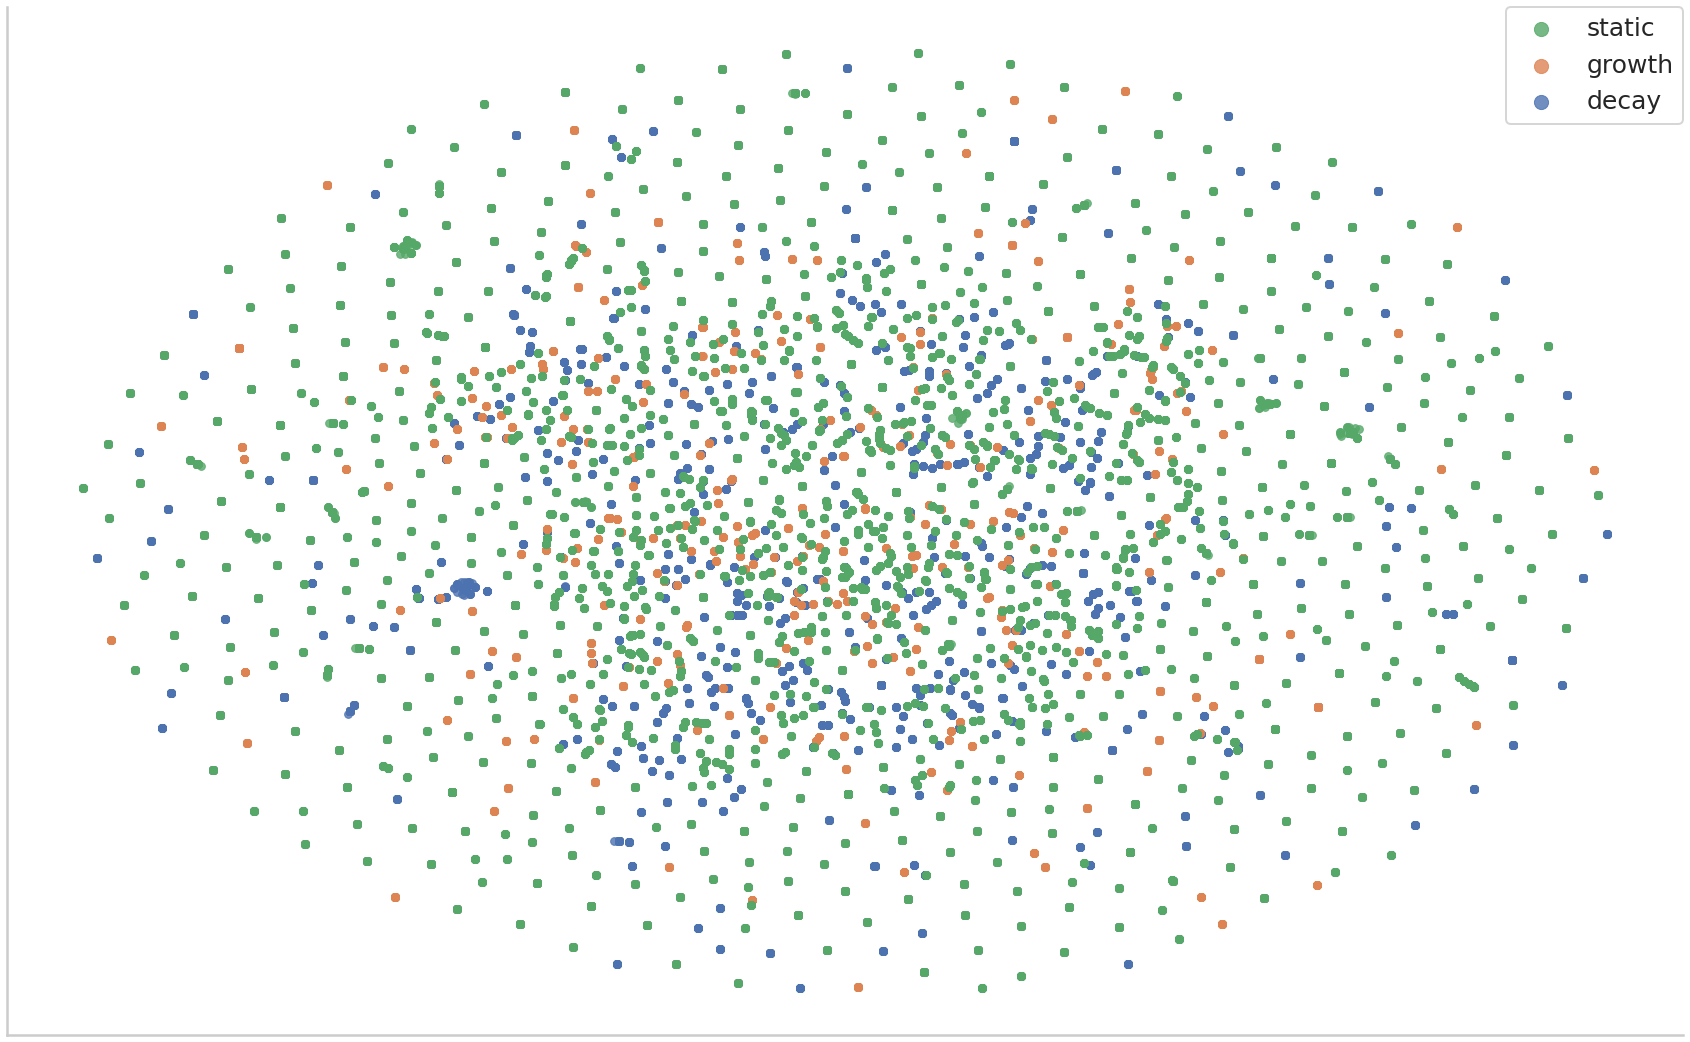

Not saved! The figure /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input2/tsne/org/train.png.png has already existed.
Not saved! The t-SNE feature file has already exited. /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input2/tsne/ros/train.npy
   label   t-SNE-1    t-SNE-2
0    2.0 -0.160568  37.958309
1    2.0 -0.160568  37.958309
2    2.0 -0.160568  37.958309
3    2.0 -0.160568  37.958309
4    2.0 -0.160568  37.958309
('2.0', '1.0', '0.0')


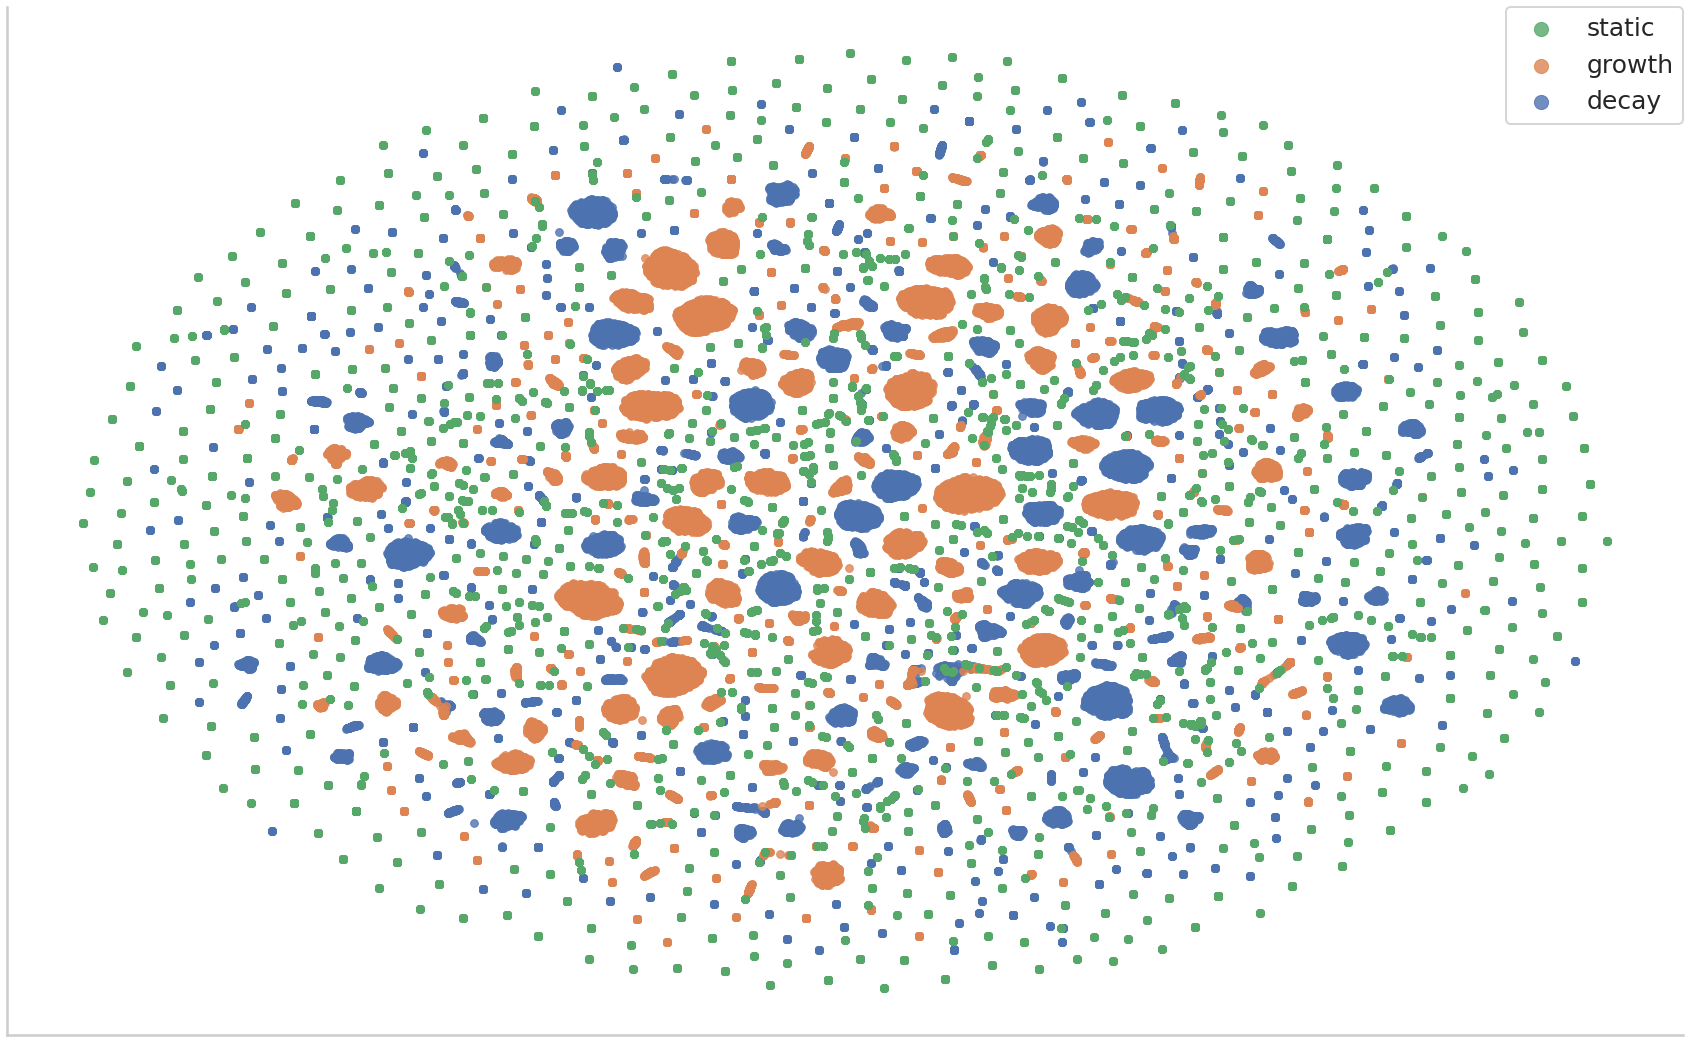

Not saved! The figure /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input2/tsne/ros/train.png.png has already existed.
Not saved! The t-SNE feature file has already exited. /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input2/tsne/smotenc/train.npy
   label   t-SNE-1    t-SNE-2
0    2.0  0.124372  35.440651
1    2.0  0.124372  35.440651
2    2.0  0.124372  35.440651
3    2.0  0.124372  35.440651
4    2.0  0.124372  35.440651
('2.0', '1.0', '0.0')


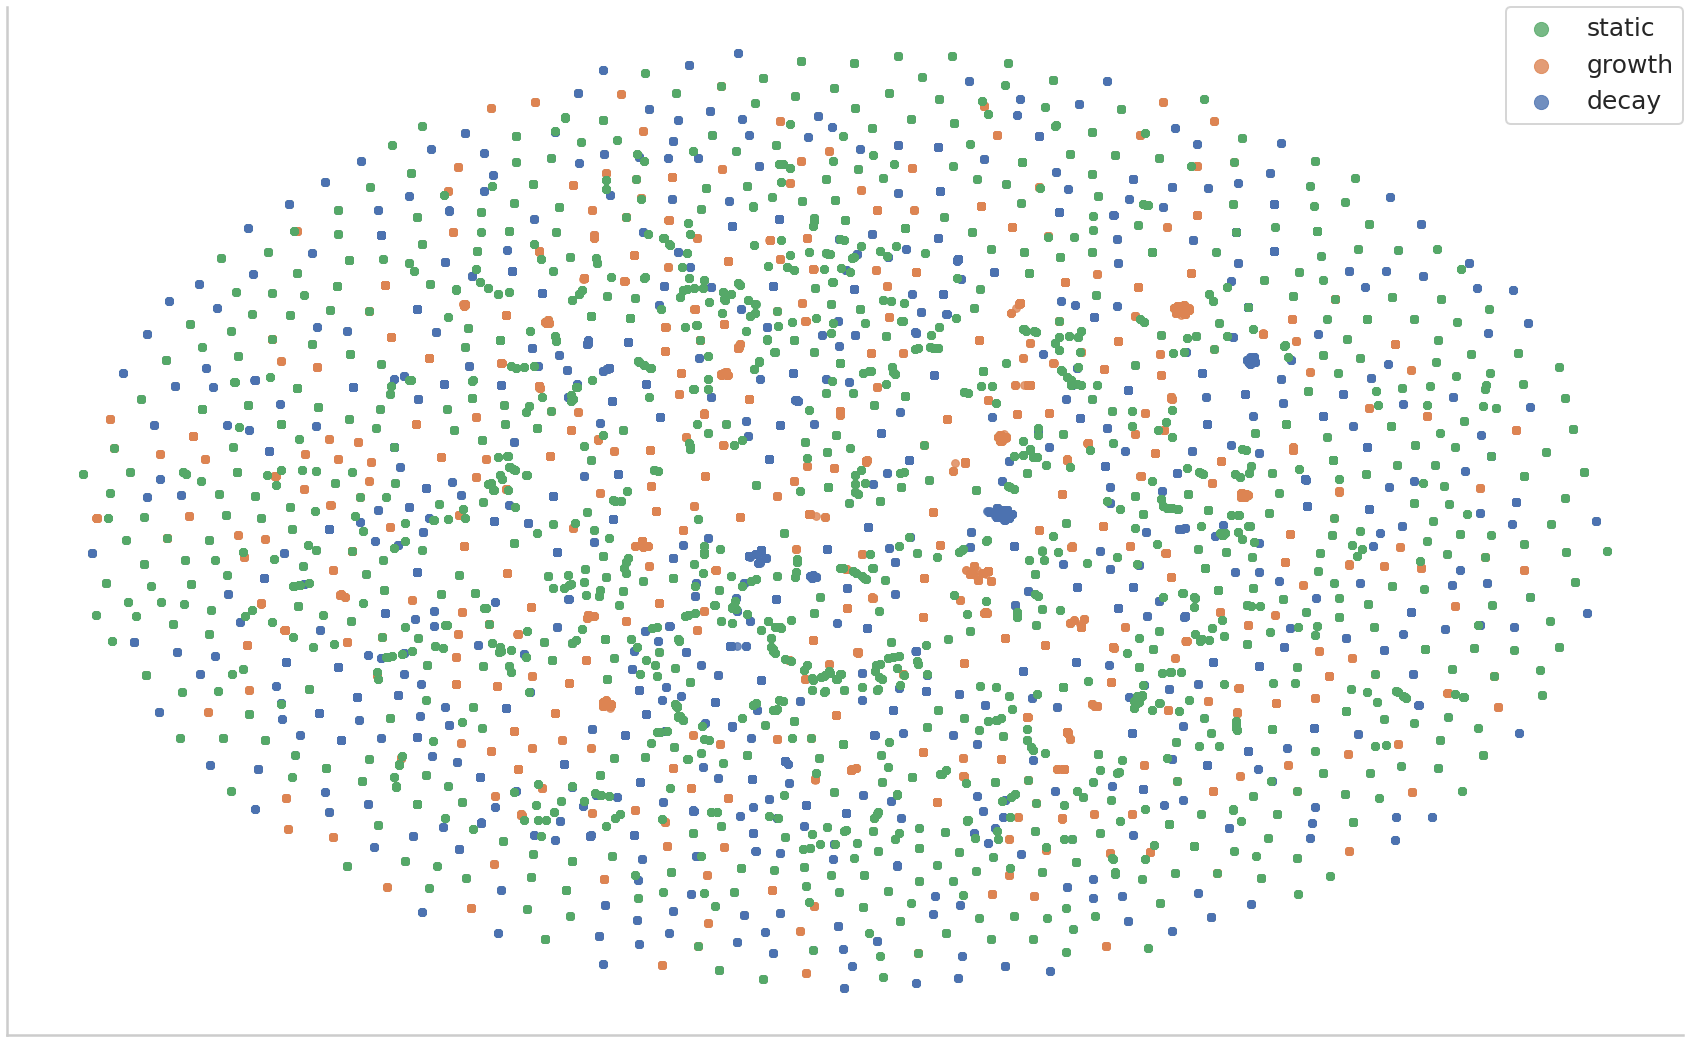

Not saved! The figure /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input2/tsne/smotenc/train.png.png has already existed.


In [19]:
from tsne import AlyTSNE
legend_info = deepcopy(label_map)
tsne_folder = f'/data/yanjun/DeepPhyTree/checkpoints/{ds_name}/split_rs{split_rs}/models_norm_input2/tsne'
os.makedirs(tsne_folder, exist_ok=True)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    if sampler_name == 'org':
        aly_train_tsne = AlyTSNE(feat=x_train_res.values, label=y_train_res.values, subset='train', save_folder=f'{tsne_folder}/{sampler_name}')
        aly_train_tsne.generate_tsne(overwrite=False)
    else:
        aly_train_tsne = AlyTSNE(feat=x_train_res.values, label=y_train_res.values, subset='train', save_folder=f'{tsne_folder}/{sampler_name}')
        aly_train_tsne.generate_tsne(overwrite=False)
    aly_train_tsne.plot(legend_info=legend_info)

Not saved! The t-SNE feature file has already exited. /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input2/tsne/org/test.npy
   label   t-SNE-1     t-SNE-2
0    2.0  7.372206  101.837090
1    2.0  7.372206  101.837090
2    2.0  7.065592  100.003075
3    2.0  7.065592  100.003075
4    2.0  7.065592  100.003075
('2.0', '1.0', '0.0')


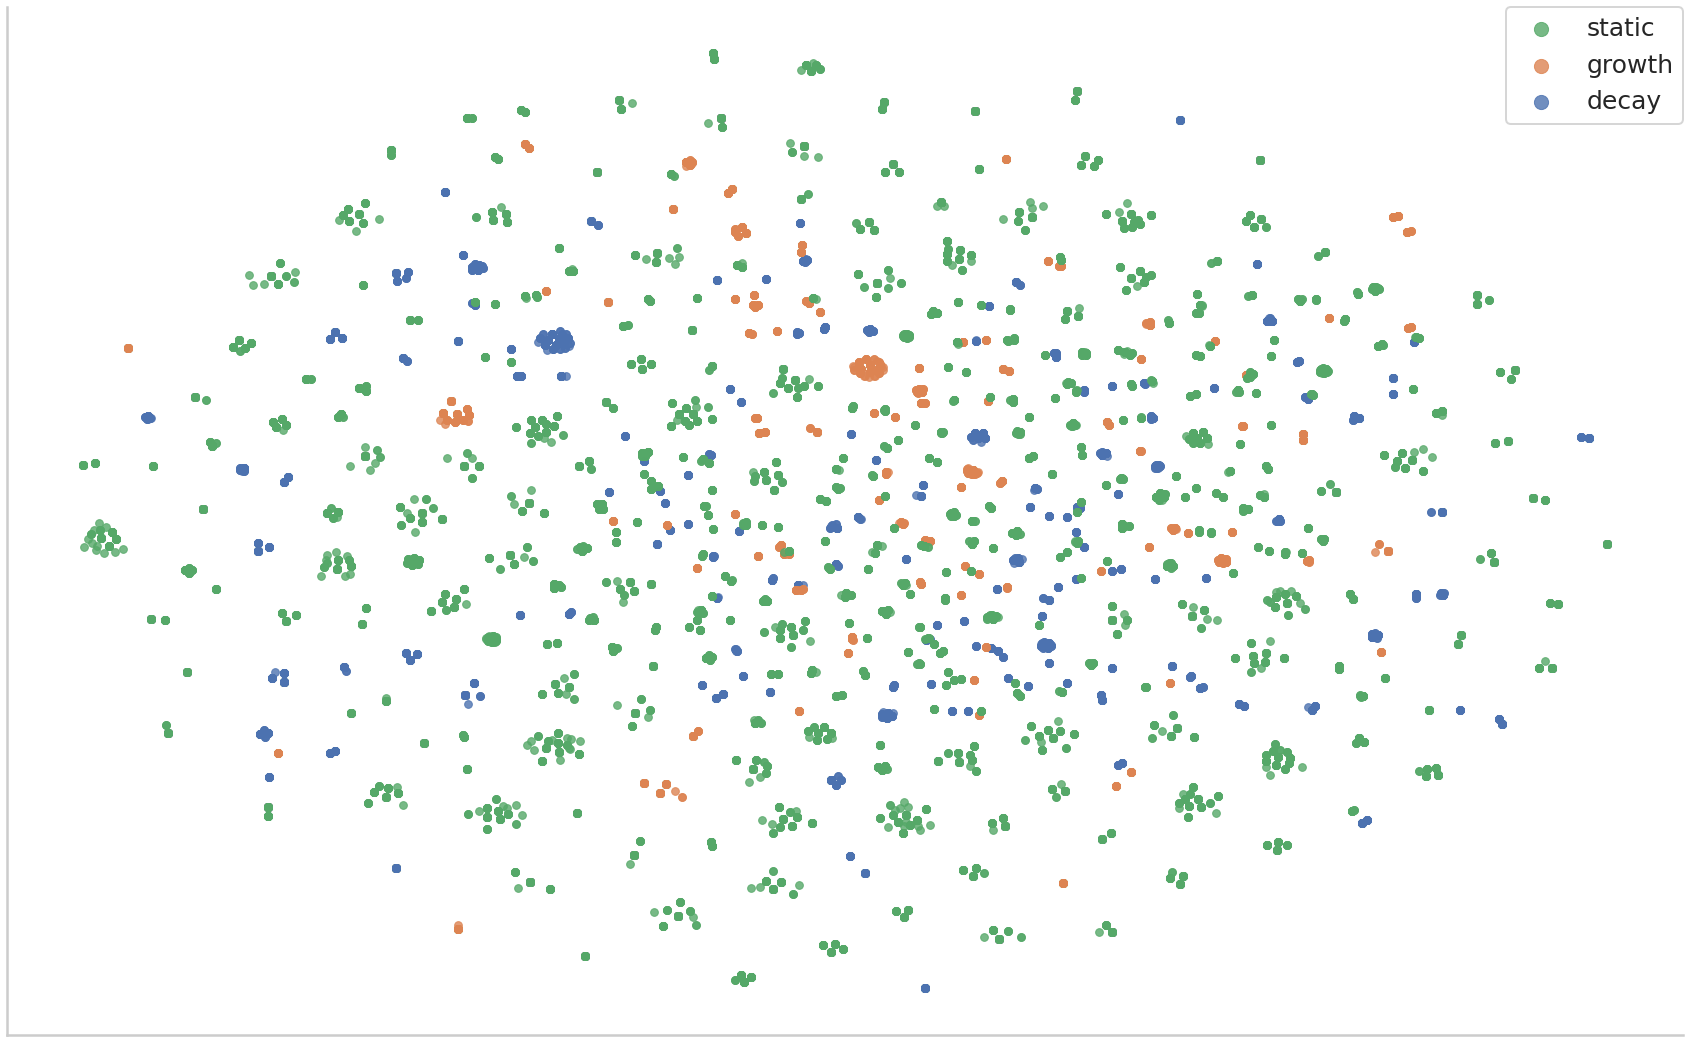

Not saved! The figure /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input2/tsne/org/test.png.png has already existed.


In [20]:
aly_test_tsne = AlyTSNE(feat=x_test.values, label=y_test.values, subset='test', save_folder=f'{tsne_folder}/org')
aly_test_tsne.generate_tsne(overwrite=False)
aly_test_tsne.plot(legend_info=legend_info)

### Cross-validation 

In [21]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, GroupKFold
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score

n_folds = 5
print(f"CV: {n_folds}")

monitor_metric = None # 'f1_weighted'  # balanced_accuracy

# Set a seed for results reproduction
np.random.seed(0)

# Apply cross validation to select the best hyperparameters
# Note: cross validation split should work on the tree id, not node id.
# Incorrect: kf = KFold(n_folds,shuffle=True).split(x)

def cv_train(model, x, y, treeids):
    # TODO: verify the the groups for x
    gkf = GroupKFold(n_splits=5).split(x, groups=treeids)
    cv_val = cross_val_score(model, x, y, scoring=monitor_metric, cv=gkf)
    if not monitor_metric:
        return np.mean(cv_val), 'loss'
    return np.mean(cv_val), monitor_metric

CV: 5


In [22]:
model_folder = f'/data/yanjun/DeepPhyTree/checkpoints/{ds_name}/split_rs{split_rs}/models_norm_input2'
os.makedirs(model_folder, exist_ok=True)

In [23]:
# Onehot the label
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, roc_auc_score, roc_curve

classes = np.unique(y_train)
n_classes = len(classes)
label_encode_dict = feat_desc['dynamic']

y_test_onehot = label_binarize(y_test, classes=classes)
            
def get_fpr_tpr(n_classes, y_test_onehot, y_test_predscore):    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_test_predscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    # Micro-average: Calculate metrics globally by considering each element of the label indicator matrix as a label.
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_test_predscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

def plot_roc(n_classes, fpr, tpr, roc_auc):
    fig, axs = plt.subplots(1, 3, figsize=(25, 6))
    lw = 2

    for i, class_id in enumerate(range(n_classes)):
        ax = axs[i]
        ax.plot(fpr[class_id], tpr[class_id], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[class_id])
        ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=25)
        ax.set_ylabel('True Positive Rate', fontsize=25)
        if i != 0:
            ax.set_ylabel('')
        ax.set_title(f'ROC for {label_encode_dict[str(class_id)]}-{class_id}')
        ax.legend(loc="lower right")
    plt.show()    
        
def cal_auc(y_test_onehot, y_test_predscore, metric_dict):
    macro_roc_auc_ovo = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovo",
                                  average="macro")
    # 'weighted': Calculate metrics for each label, and find their average, 
    # weighted by support (the number of true instances for each label).
    weighted_roc_auc_ovo = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovo",
                                         average="weighted") 
    macro_roc_auc_ovr = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovr",
                                         average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    
    metric_dict['macro_auc_ovo'].append(macro_roc_auc_ovo)
    metric_dict['weighted_auc_ovo'].append(weighted_roc_auc_ovo)
    metric_dict['macro_auc_ovr'].append(macro_roc_auc_ovr)
    metric_dict['weighted_auc_ovr'].append(weighted_roc_auc_ovr)

In [24]:
from numpy import interp
from itertools import cycle

def plot_merged_roc(n_classes, fpr):
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Calculate metrics for each label, and find their unweighted mean (by linear interpolation). 
    # This does not take label imbalance into account.
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [25]:
def cal_basic_metric(y_test, y_test_pred, metric_dict):
    acc = accuracy_score(y_test, y_test_pred)
    print(f'Test Acc: {acc}')

    bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    print(f'Test Ballance Acc: {bal_acc}')

    f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
    print(f'Test F1: {f1_weighted}')
    
    metric_dict['acc'].append(acc)
    metric_dict['balance_acc'].append(bal_acc)
    metric_dict['f1_weighted'].append(f1_weighted)

In [26]:
def eval_classifer(model, x_test, y_test, metric_dict):
    y_test_pred = model.predict(x_test)
    y_test_predscore = model.predict_proba(x_test)

    cal_basic_metric(y_test, y_test_pred, metric_dict)
    cal_auc(y_test_onehot, y_test_predscore, metric_dict)
    
    fpr, tpr, roc_auc = get_fpr_tpr(n_classes, y_test_onehot, y_test_predscore)
    plot_roc(n_classes, fpr, tpr, roc_auc)
    

In [27]:
def get_best_classifer(model, cv_func, x_train, y_train, treeid_train, x_test, y_test, metric_dict):
    model.fit(x_train, y_train, cv_func, treeid_train)
    model.best_classifer.fit(x_train, y_train)
    return model.best_classifer

### Softmax regression

===Model for org data===
best validation loss achieved: 0.6263737415772292
Test Acc: 0.6329181876744685
Test Ballance Acc: 0.6406205918338111
Test F1: 0.6823141710877835
One-vs-One ROC AUC scores:
0.796091 (macro),
0.806713 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.796091 (macro),
0.806713 (weighted by prevalence)


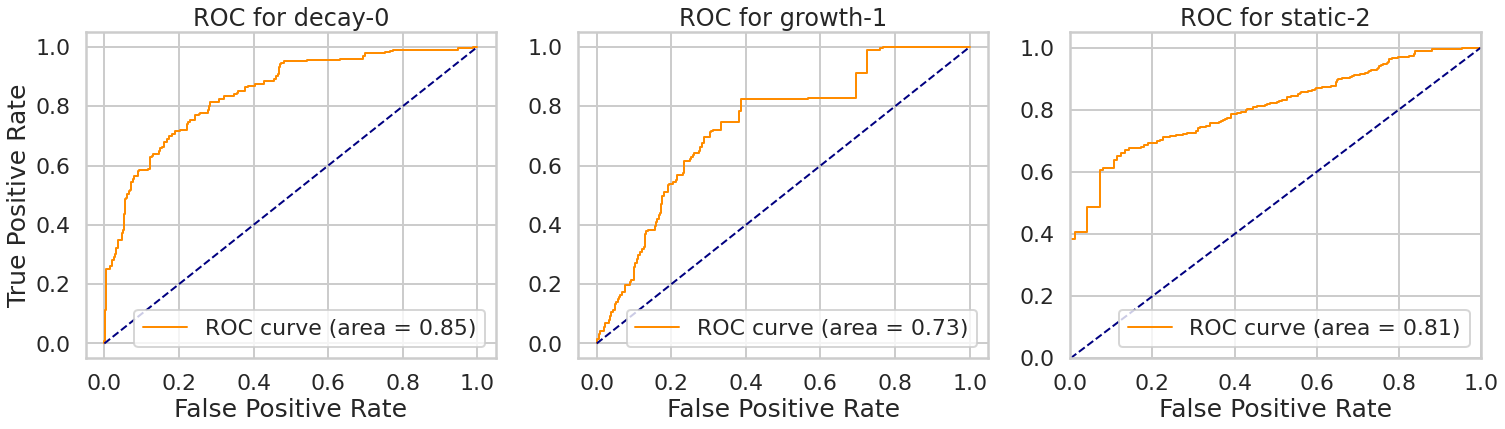



===Model for ros data===
best validation loss achieved: 0.6526247089245898
Test Acc: 0.6246510629160403
Test Ballance Acc: 0.6354657633872322
Test F1: 0.6727170177125454
One-vs-One ROC AUC scores:
0.791048 (macro),
0.800084 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.791048 (macro),
0.800084 (weighted by prevalence)


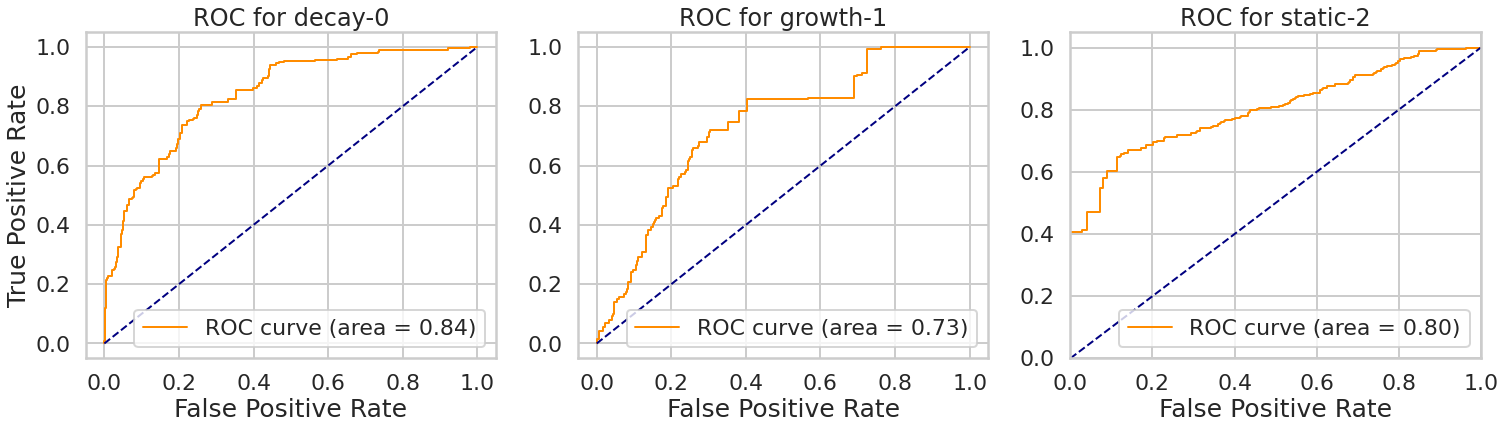



===Model for smotenc data===
best validation loss achieved: 0.6444669032894402
Test Acc: 0.6333476487008805
Test Ballance Acc: 0.6440374822459917
Test F1: 0.6811164343949963
One-vs-One ROC AUC scores:
0.794745 (macro),
0.803083 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.794745 (macro),
0.803083 (weighted by prevalence)


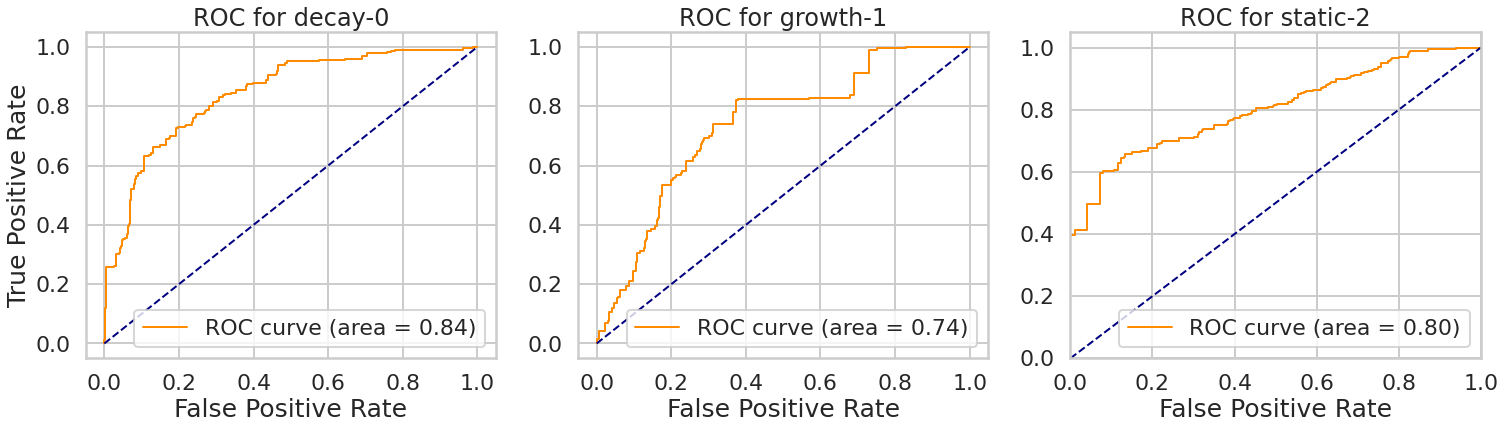

In [28]:
from base_model import Sfmx
from collections import defaultdict

sfmx_model_dict = dict()
sfmx_metric_dict = defaultdict(list)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    print(f"===Model for {sampler_name} data===")
    
    np.random.seed(0)
    model = Sfmx()
    best_model = get_best_classifer(model, cv_train, x_train_res, y_train_res, treeid_train, 
                                    x_test, y_test, sfmx_metric_dict)
    sfmx_metric_dict['model'].append('softmax')
    sfmx_metric_dict['sampler_name'].append(sampler_name)
    eval_classifer(best_model, x_test, y_test, sfmx_metric_dict)
    sfmx_model_dict[sampler_name] = best_model
    print('\n')

In [29]:
sfmx_metric_df = pd.DataFrame.from_dict(sfmx_metric_dict)
sfmx_metric_df

,model,sampler_name,acc,balance_acc,f1_weighted,macro_auc_ovo,weighted_auc_ovo,macro_auc_ovr,weighted_auc_ovr
0,softmax,org,0.632918,0.640621,0.682314,0.796091,0.806713,0.796091,0.806713
1,softmax,ros,0.624651,0.635466,0.672717,0.791048,0.800084,0.791048,0.800084
2,softmax,smotenc,0.633348,0.644037,0.681116,0.794745,0.803083,0.794745,0.803083


### Coef visualization

In [30]:
def vis_coef(model):
    # print(model.coef_.shape)
    enc_label = list(map(int, sorted(y_test.unique())))
    # print(enc_label)

    coef_df = pd.DataFrame(model.coef_, index=enc_label, columns=input_feat)
    # print(coef_df.head())
    
    coef_ranked_dict = dict()
    fig, axs = plt.subplots(1, 3, figsize=(18, 12))
    for i, label in enumerate(enc_label):
        coef = coef_df.iloc[label]
        
        # Norm the coef
        min_coef, max_coef = min(abs(coef)), max(abs(coef))
        coef = (coef - min_coef) / (max_coef - min_coef)
        
        coef_ranked_dict[label] = sorted(zip(input_feat, coef), key=lambda x: abs(x[1]), reverse=True)
        g = sns.barplot(y=input_feat, x=coef, ax=axs[i])
        if i != 0:
            g.set(yticklabels=[])
    plt.show()
    return coef_ranked_dict

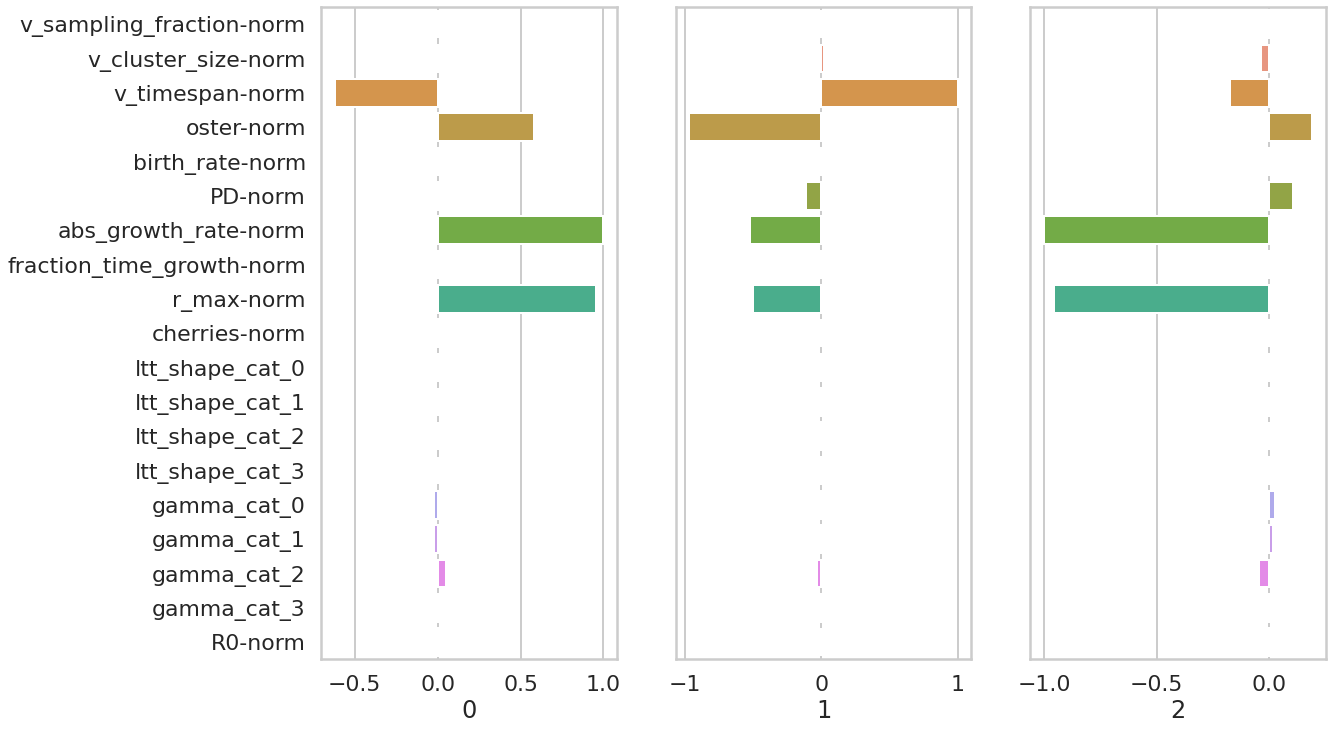

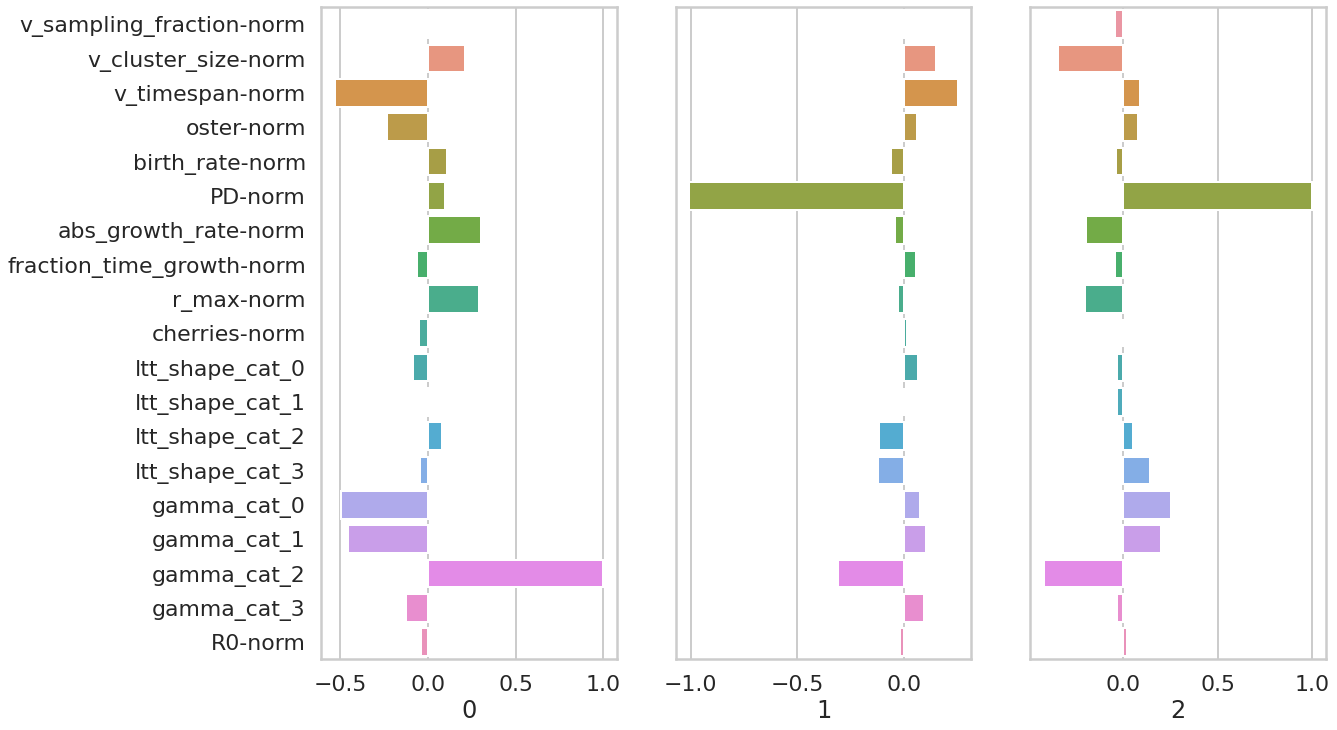

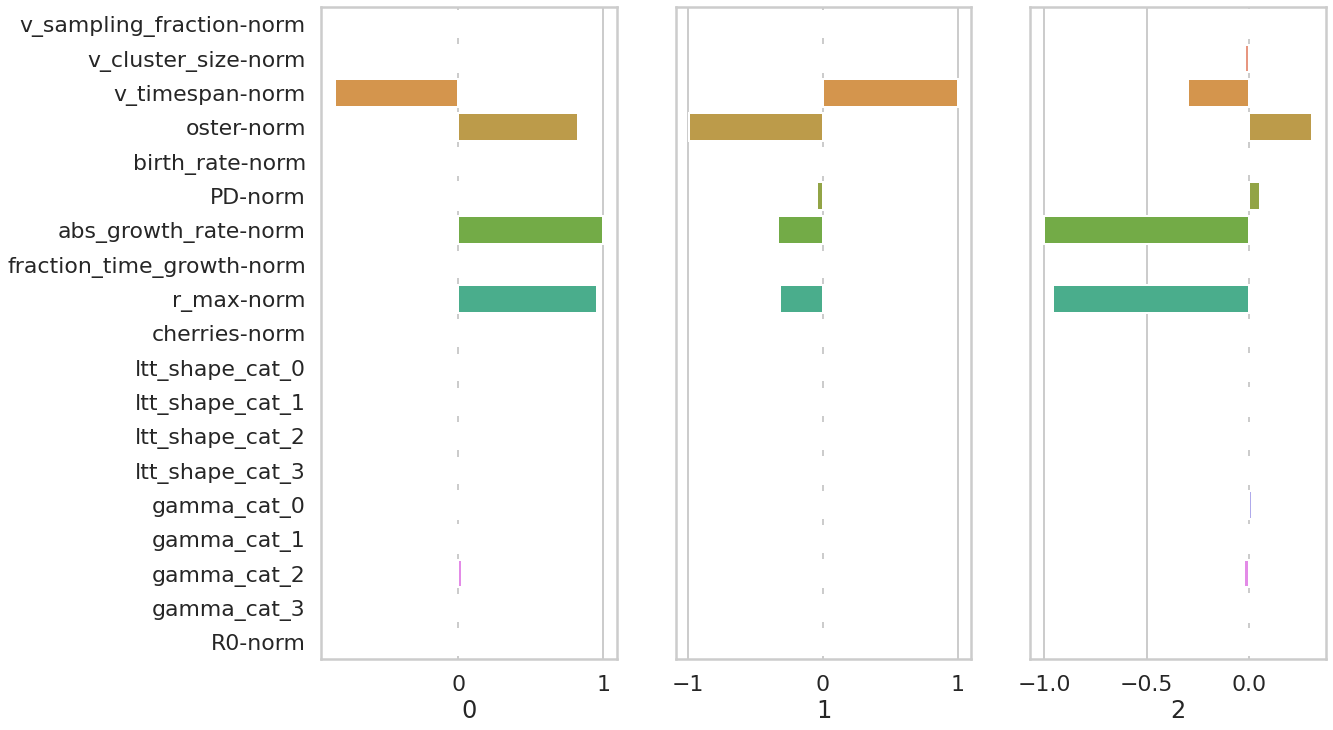

In [31]:
for sampler_type in train_data_dict.keys():
    coef_dict = vis_coef(sfmx_model_dict[sampler_type])

### Save the model 

In [32]:
from joblib import dump, load

def save(model_dict, model_name):
    dump(model_dict, osp.join(model_folder, f'{model_name}.joblib'))

In [33]:
save(sfmx_model_dict, 'sfmx')

### Linear regression with one-vs-rest (OvR) scheme

===Model for org data===


/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


best validation loss achieved: 0.6256098750432109
Test Acc: 0.6395211509555507
Test Ballance Acc: 0.62532277519644
Test F1: 0.6882389833580987
One-vs-One ROC AUC scores:
0.801598 (macro),
0.810430 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.801598 (macro),
0.810430 (weighted by prevalence)


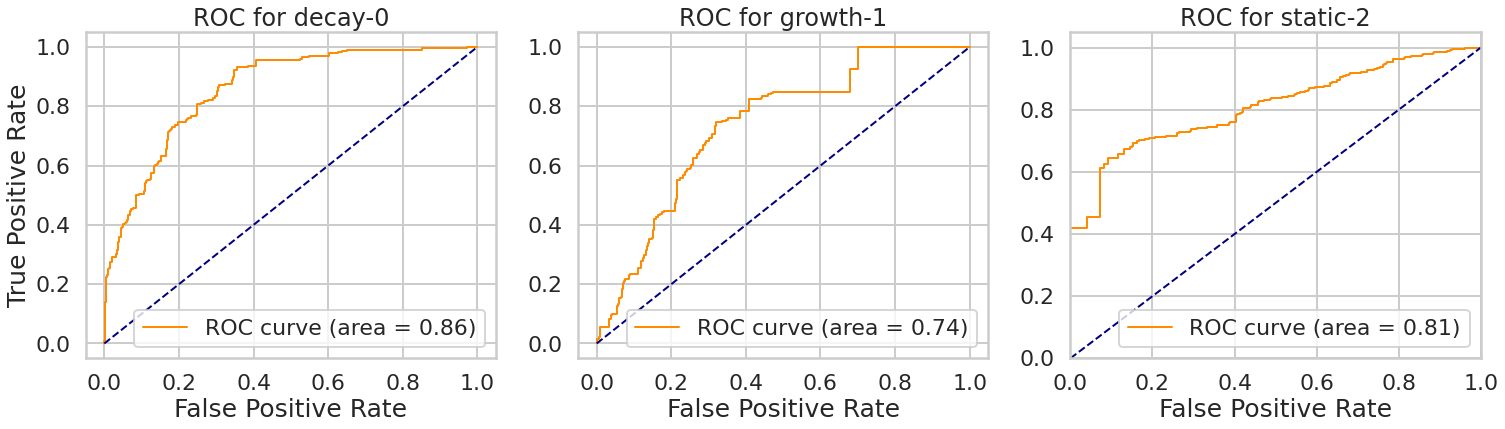



===Model for ros data===
best validation loss achieved: 0.6431775324656017
Test Acc: 0.6311466609405196
Test Ballance Acc: 0.6362640933460669
Test F1: 0.6808905870743812
One-vs-One ROC AUC scores:
0.787436 (macro),
0.795910 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.787436 (macro),
0.795910 (weighted by prevalence)


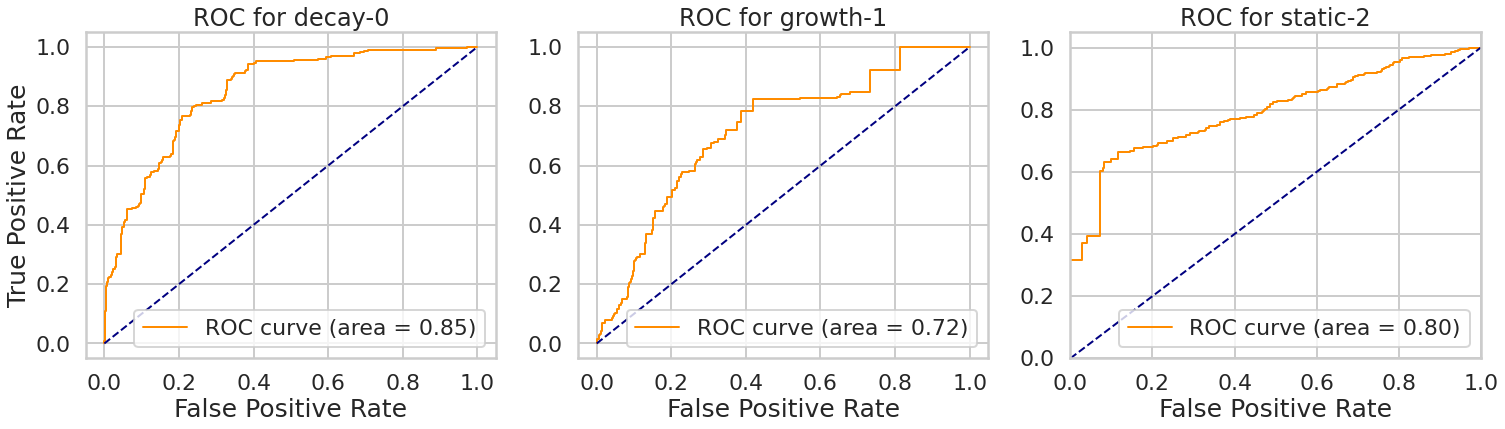



===Model for smotenc data===


/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not conv

best validation loss achieved: 0.6374707659131065
Test Acc: 0.6497208503328323
Test Ballance Acc: 0.6524246966651135
Test F1: 0.6990546352157151
One-vs-One ROC AUC scores:
0.791572 (macro),
0.802323 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.791572 (macro),
0.802323 (weighted by prevalence)


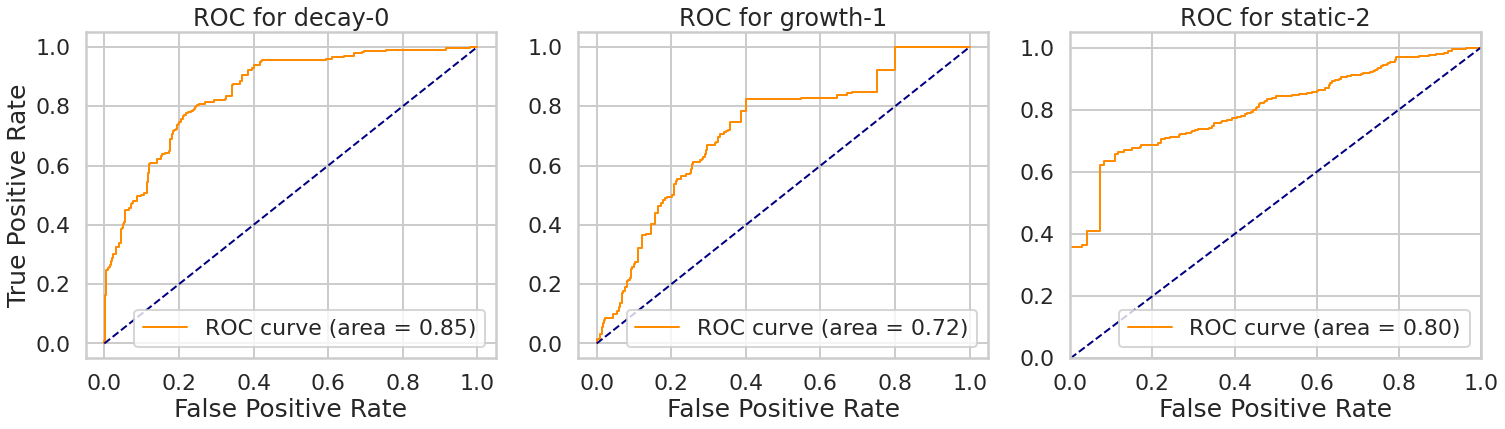

In [34]:
# from base_model import Sfmx

sfmx_ovr_model_dict = dict()
sfmx_ovr_metric_dict = defaultdict(list)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    print(f"===Model for {sampler_name} data===")
    
    np.random.seed(0)
    model = Sfmx(multi_class='ovr')
    best_model = get_best_classifer(model, cv_train, x_train_res, y_train_res, treeid_train, 
                                    x_test, y_test, sfmx_ovr_metric_dict)
    sfmx_ovr_metric_dict['model'].append('softmax_ovr')
    sfmx_ovr_metric_dict['sampler_name'].append(sampler_name)
    eval_classifer(best_model, x_test, y_test, sfmx_ovr_metric_dict)
    sfmx_ovr_model_dict[sampler_name] = best_model
    print('\n')

In [35]:
sfmx_ovr_metric_df = pd.DataFrame.from_dict(sfmx_metric_dict)
sfmx_ovr_metric_df

,model,sampler_name,acc,balance_acc,f1_weighted,macro_auc_ovo,weighted_auc_ovo,macro_auc_ovr,weighted_auc_ovr
0,softmax,org,0.632918,0.640621,0.682314,0.796091,0.806713,0.796091,0.806713
1,softmax,ros,0.624651,0.635466,0.672717,0.791048,0.800084,0.791048,0.800084
2,softmax,smotenc,0.633348,0.644037,0.681116,0.794745,0.803083,0.794745,0.803083


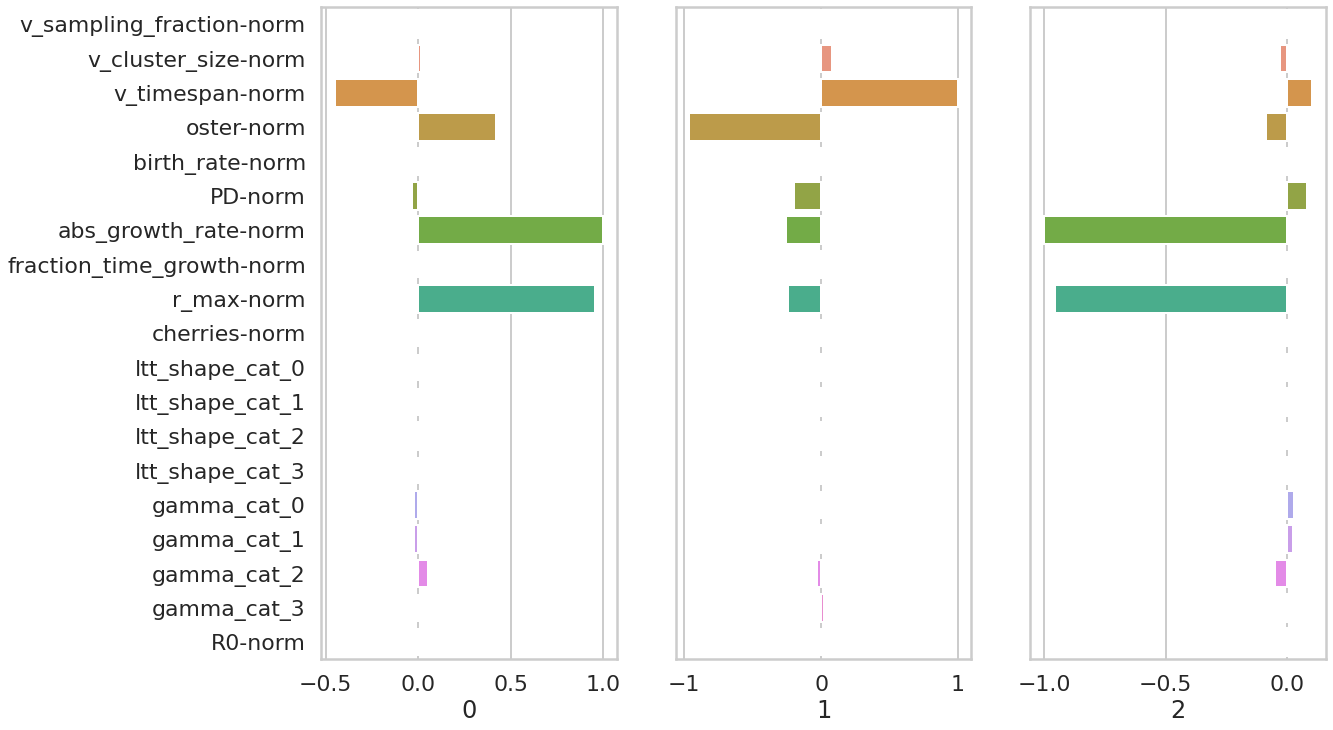

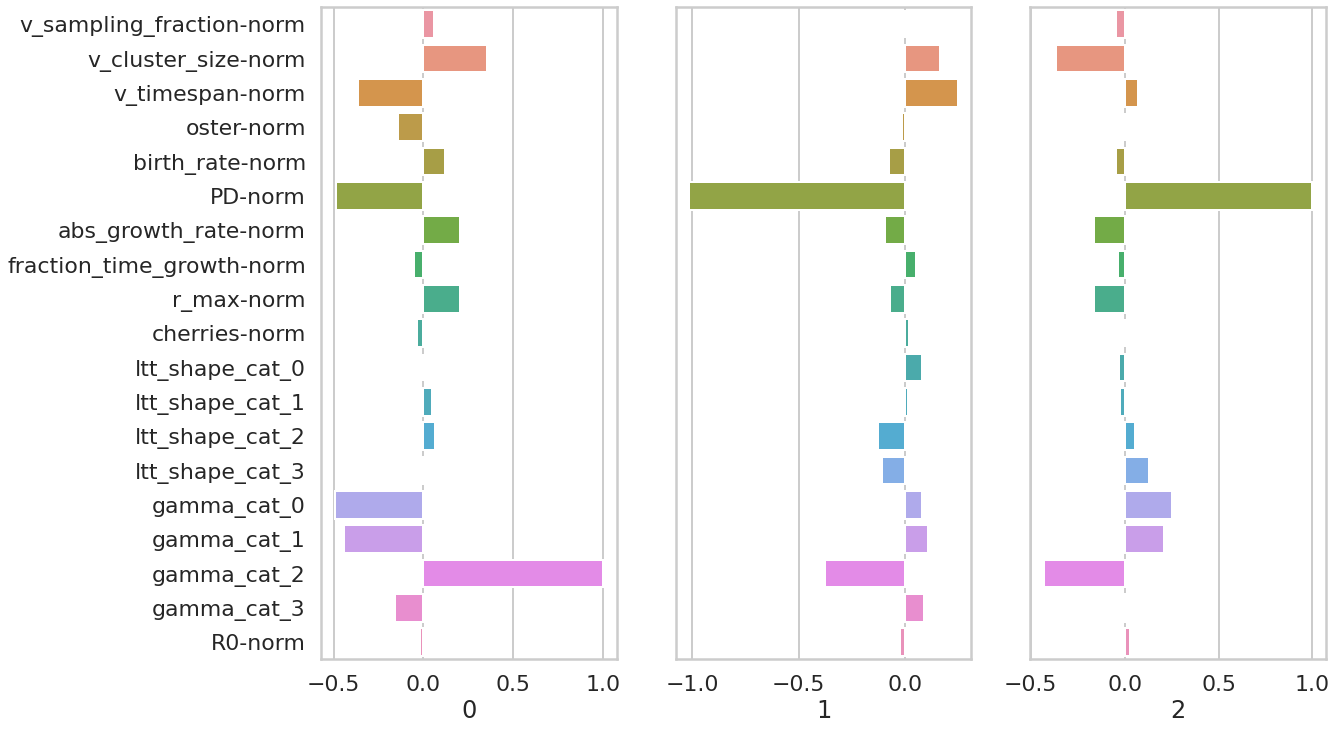

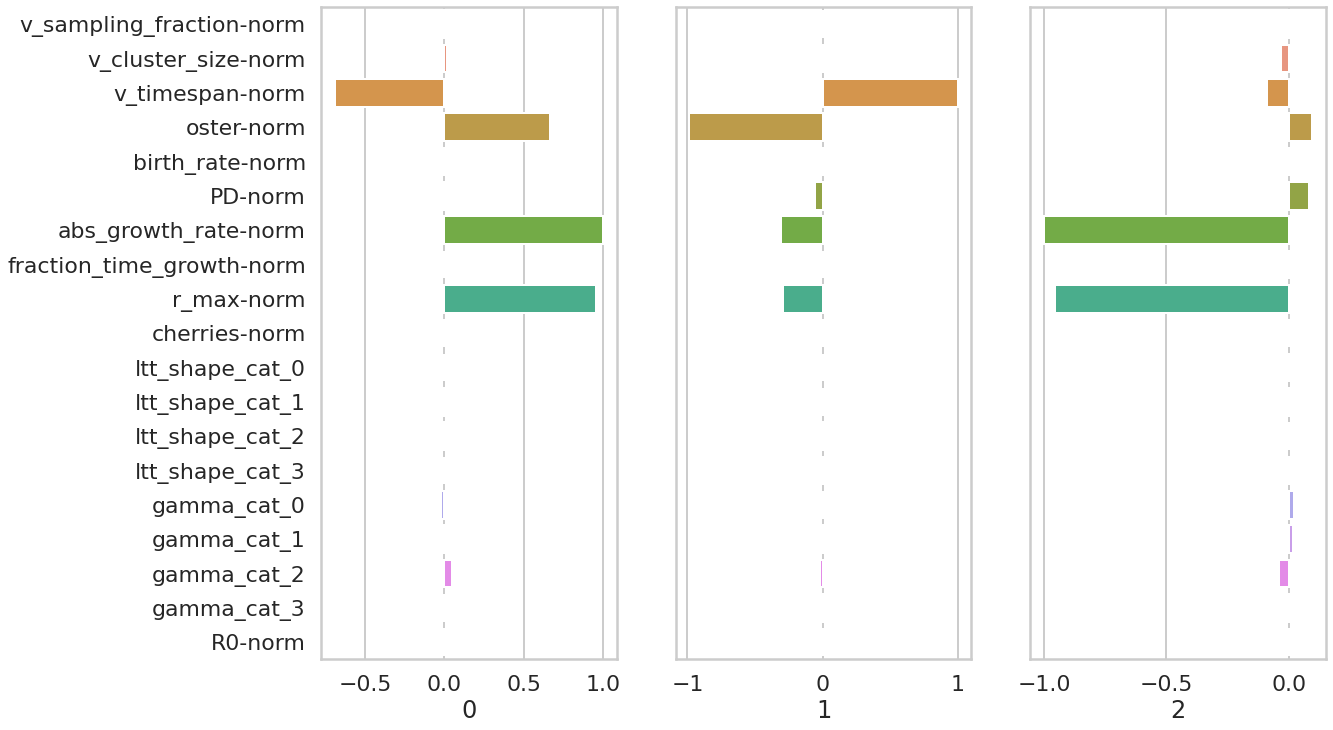

In [36]:
for sampler_type in train_data_dict.keys():
    coef_dict = vis_coef(sfmx_ovr_model_dict[sampler_type])

In [37]:
save(sfmx_model_dict, 'sfmx_ovr')

### Random Forest

===Model for org data===
best validation loss achieved: 0.6293172471007494
Test Acc: 0.6481103714837878
Test Ballance Acc: 0.711602415752394
Test F1: 0.6938217943645453
One-vs-One ROC AUC scores:
0.859043 (macro),
0.852908 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.859043 (macro),
0.852908 (weighted by prevalence)


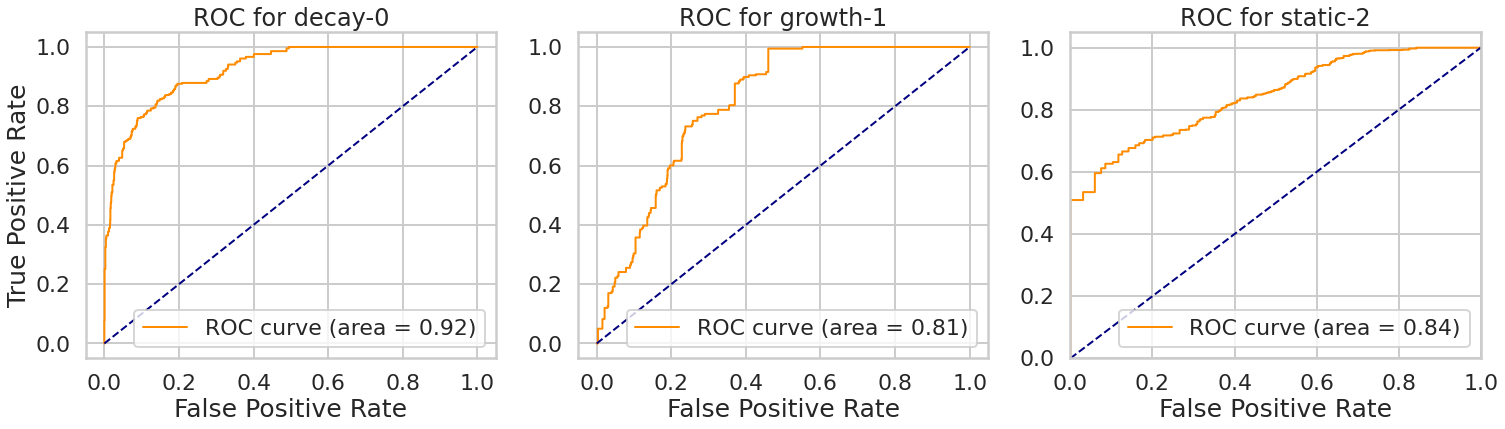



===Model for ros data===
best validation loss achieved: 0.8843269327072971
Test Acc: 0.7524157182735667
Test Ballance Acc: 0.4410631048091605
Test F1: 0.6982568313182574
One-vs-One ROC AUC scores:
0.825099 (macro),
0.831012 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.825099 (macro),
0.831012 (weighted by prevalence)


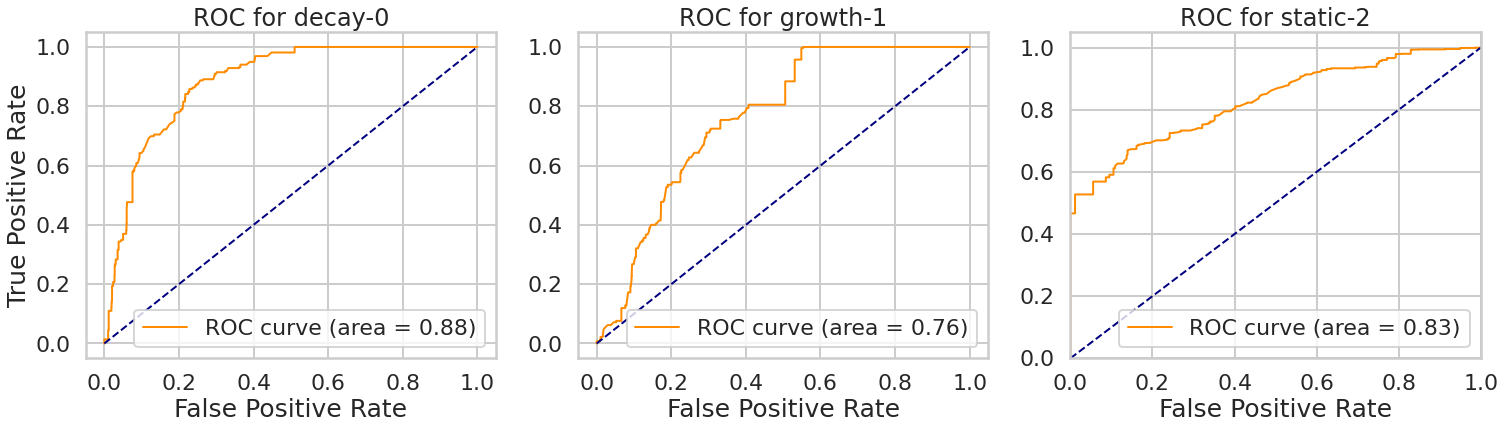



===Model for smotenc data===
best validation loss achieved: 0.5567184388904505
Test Acc: 0.8219347219239854
Test Ballance Acc: 0.5623160045866218
Test F1: 0.7849495149308462
One-vs-One ROC AUC scores:
0.859816 (macro),
0.868550 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.859816 (macro),
0.868550 (weighted by prevalence)


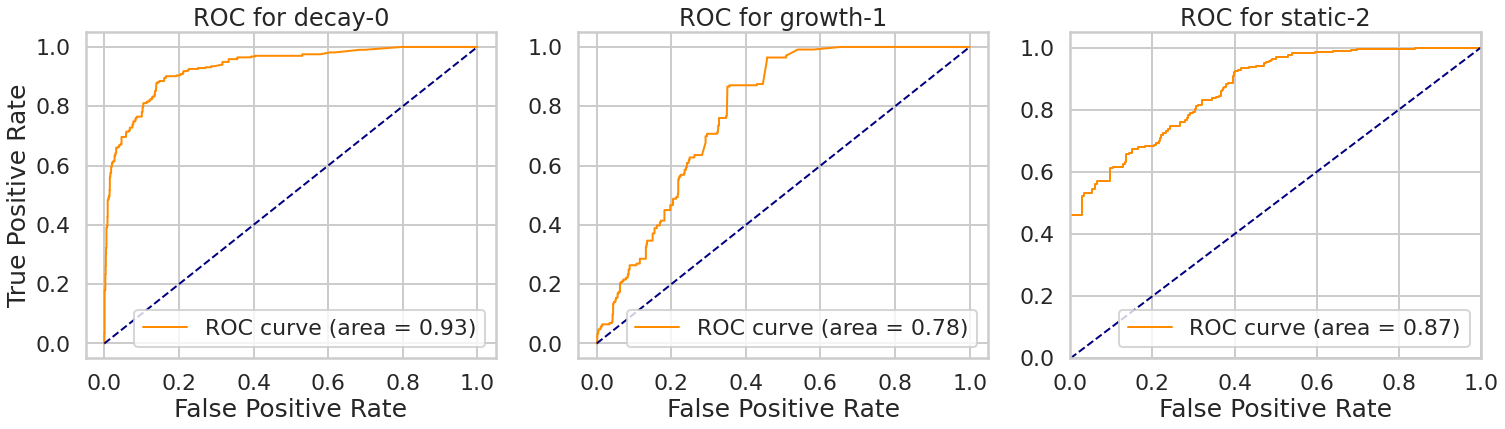

In [38]:
from base_model import RF
from collections import defaultdict

rf_model_dict = dict()
rf_metric_dict = defaultdict(list)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    np.random.seed(0)
    print(f"===Model for {sampler_name} data===")
    
    model = RF()
    best_model = get_best_classifer(model, cv_train, x_train_res, y_train_res, treeid_train, 
                                    x_test, y_test, sfmx_metric_dict)
    rf_metric_dict['model'].append('rf')
    rf_metric_dict['sampler_name'].append(sampler_name)
    eval_classifer(best_model, x_test, y_test, rf_metric_dict)
    rf_model_dict[sampler_name] = best_model
    print('\n')

### Feature Importance

In [39]:
def cal_feat_impt(model):
    fig, axs = plt.subplots(figsize=(18, 12))

    coef_ranked_dict = dict()

    # Gini importance: The higher, the more important the feature. 
    # The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
    coef = model.feature_importances_

    coef_ranked = sorted(zip(input_feat, coef), key=lambda x: abs(x[1]), reverse=True)
    
    sns.barplot(y=input_feat, x=coef)
    print(coef_ranked)

[('oster-norm', 0.17324770702076836), ('PD-norm', 0.16668633204341152), ('v_timespan-norm', 0.1297578200786992), ('gamma_cat_2', 0.10013628102632609), ('v_cluster_size-norm', 0.09651811703206864), ('abs_growth_rate-norm', 0.09361347614827782), ('r_max-norm', 0.08291873263059016), ('birth_rate-norm', 0.06882544835712091), ('v_sampling_fraction-norm', 0.01966471060297392), ('fraction_time_growth-norm', 0.016050460704259802), ('cherries-norm', 0.015946340445530772), ('R0-norm', 0.009689838644623177), ('gamma_cat_1', 0.00770382224176171), ('gamma_cat_0', 0.006072856376305989), ('ltt_shape_cat_1', 0.004148143830085905), ('gamma_cat_3', 0.003960431157121206), ('ltt_shape_cat_0', 0.0019583509521054225), ('ltt_shape_cat_3', 0.001942637918046126), ('ltt_shape_cat_2', 0.001158492789923218)]
[('abs_growth_rate-norm', 0.2085952049483435), ('gamma_cat_2', 0.13526708216540645), ('r_max-norm', 0.13453297450269935), ('oster-norm', 0.09763603433856524), ('PD-norm', 0.09730053762281625), ('birth_rate-no

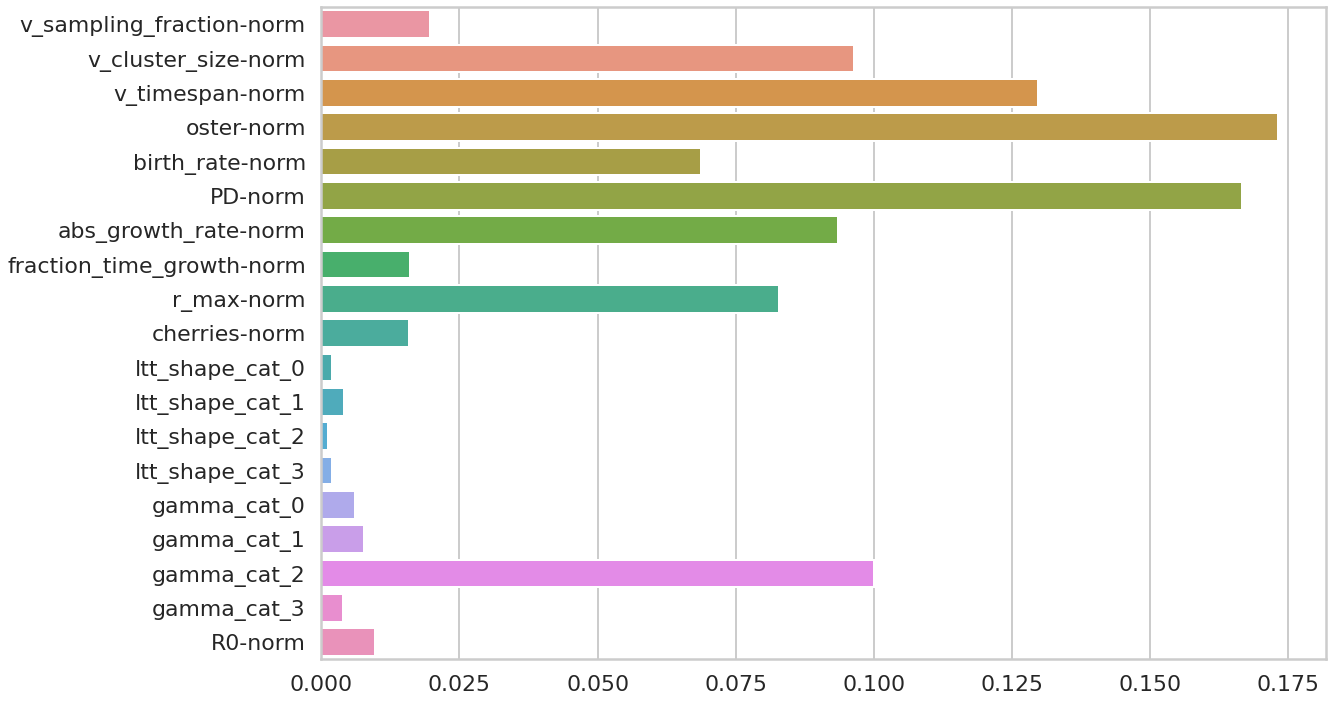

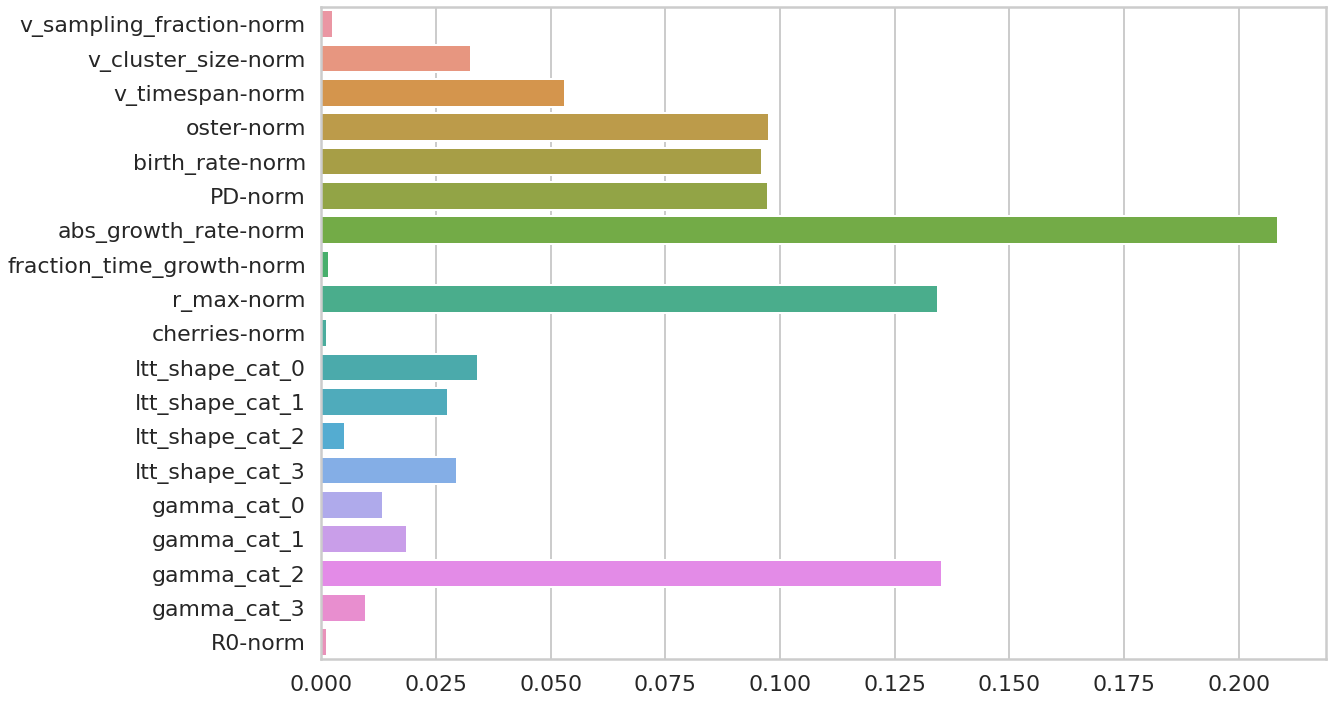

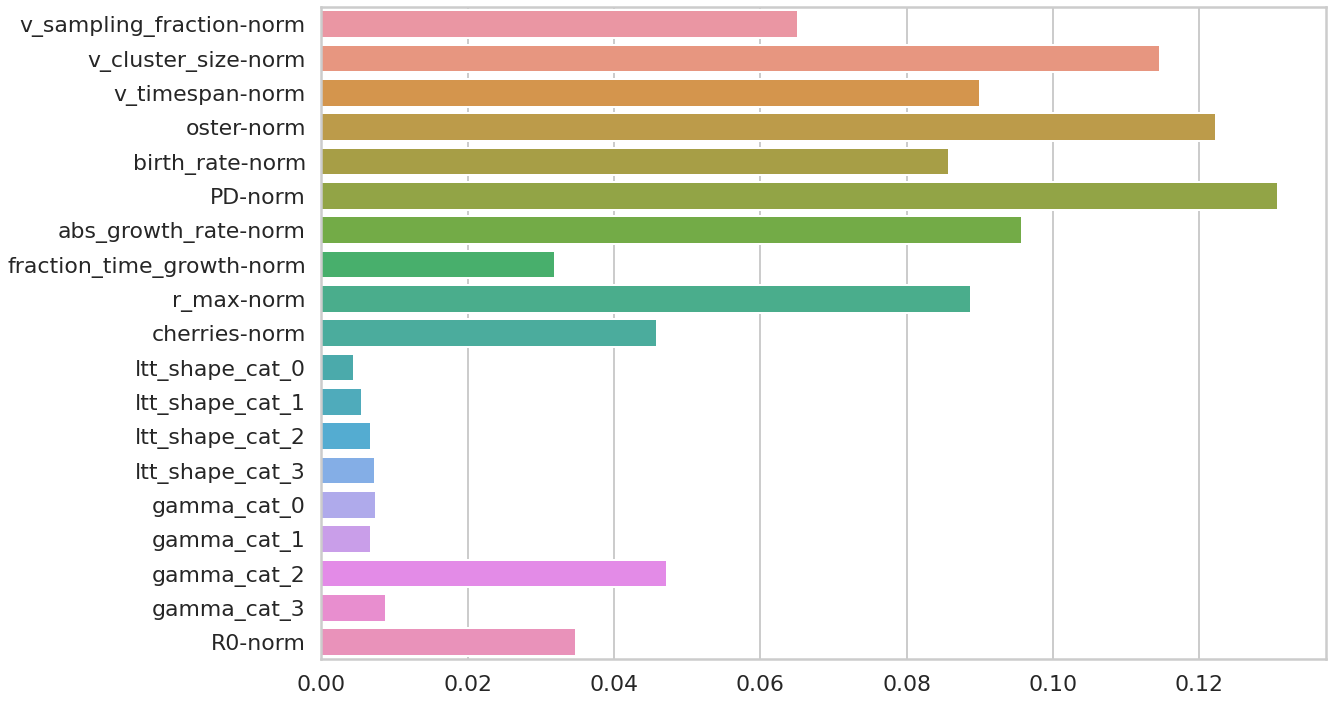

In [40]:
for sampler_type in train_data_dict.keys():
    coef_dict = cal_feat_impt(rf_model_dict[sampler_type])

In [41]:
save(rf_model_dict, 'rf')

### Analyze the mis-classcification 

In [42]:
def get_misclass(y_true, y_pred):
    mis_id_dict = defaultdict(dict)
    mis_ids = y_true != y_pred
    print(f'Total Mis: {sum(mis_ids)}, ({100 * sum(mis_ids) / len(y_true):.3f}%)')
    
    print(label_map)
    for i in range(len(label_map)):
        label_ids = y_true == i
        sub_mis_id_dict = defaultdict(list)
        
        for idx, (label_id, mis_id) in enumerate(zip(label_ids, mis_ids)):
            if label_id and mis_id:
                sub_mis_id_dict[y_pred[idx]].append(idx)
        
        n_mis = sum([len(mis_lst) for mis_lst in sub_mis_id_dict.values()])
        n_sample = sum(label_ids)
        
        print(f'Mis-classified of {label_map[i]}: {n_mis}/{n_sample}, ({100 * n_mis / n_sample:.3f}%)')
        for mis_label, mis_lst in sub_mis_id_dict.items():
            print(f'\t{mis_label}: {len(mis_lst)}')
        
        mis_id_dict[i] = sub_mis_id_dict
    return mis_id_dict

In [43]:
rf_model = rf_model_dict['org']
y_test_pred = rf_model.predict(x_test)
y_test_predscore = rf_model.predict_proba(x_test)
y_test_arr = y_test.values

mis_id_dict = get_misclass(y_test_arr, y_test_pred)

Total Mis: 6555, (35.189%)
{0: 'decay', 1: 'growth', 2: 'static'}
Mis-classified of decay: 749/3051, (24.549%)
	1.0: 749
Mis-classified of growth: 444/1967, (22.572%)
	0.0: 145
	2.0: 299
Mis-classified of static: 5362/13610, (39.398%)
	0.0: 1283
	1.0: 4079


In [44]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_arr, y_test_pred)
conf_mat

array([[2302,  749,    0],
       [ 145, 1523,  299],
       [1283, 4079, 8248]])

In [45]:
list(label_map.values())

['decay', 'growth', 'static']

[None, None, None, None, None, None]

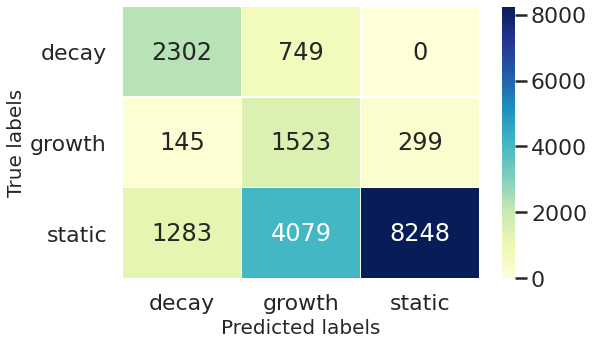

In [46]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu", ax=ax)
ax.set_ylabel('True labels', fontsize=20)
ax.set_xlabel('Predicted labels', fontsize=20)

ax.set_xticklabels(list(label_map.values()))
ax.set_yticklabels(list(label_map.values()))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

In [47]:
# Merget the test data and prediction
y_test_true_df = pd.DataFrame({'true': y_test})
y_test_pred_df = pd.DataFrame({'pred': y_test_pred})
test_pred_df = pd.concat([x_test, y_test_true_df, y_test_pred_df], axis=1)
test_pred_df.to_csv(osp.join(model_folder, 'rf_org_pred.csv'), index=False)

test_pred_df.tail()

,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,...,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,R0-norm,true,pred
18623,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.240204e-16,2.0,1.0
18624,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.240204e-16,2.0,1.0
18625,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.240204e-16,2.0,1.0
18626,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.240204e-16,2.0,1.0
18627,0.887591,-0.632966,-1.217582,-1.216423,-0.054812,-0.891082,-0.02868,-1.270158,0.024577,-2.473886,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.240204e-16,2.0,1.0


In [48]:
legend_info

{0: 'decay', 1: 'growth', 2: 'static'}

In [49]:
pred_label_map = deepcopy(label_map)
extend_legend_info = deepcopy(legend_info)

rvs_pred_label_map = defaultdict(dict)
new_label = len(label_map)

for label in range(n_classes):
    for mis_pred in range(n_classes):
        if label != mis_pred:
            rvs_pred_label_map[label][mis_pred] = new_label
            pred_label_map[new_label] = {'true': label, 'pred': mis_pred}
            extend_legend_info[new_label] = f'{label_map[label]}->{label_map[mis_pred]}'
            new_label += 1
pred_label_map

{0: 'decay',
 1: 'growth',
 2: 'static',
 3: {'true': 0, 'pred': 1},
 4: {'true': 0, 'pred': 2},
 5: {'true': 1, 'pred': 0},
 6: {'true': 1, 'pred': 2},
 7: {'true': 2, 'pred': 0},
 8: {'true': 2, 'pred': 1}}

In [50]:
extend_legend_info

{0: 'decay',
 1: 'growth',
 2: 'static',
 3: 'decay->growth',
 4: 'decay->static',
 5: 'growth->decay',
 6: 'growth->static',
 7: 'static->decay',
 8: 'static->growth'}

In [51]:
extend_y_test_pred = []

for y_true, y_pred in zip(y_test, y_test_pred):
    if y_true == y_pred:
        extend_y_test_pred.append(y_true)
    else:
        extend_label = rvs_pred_label_map[y_true][y_pred]
        extend_y_test_pred.append(extend_label)
print(extend_y_test_pred[-10:])

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


Not saved! The t-SNE feature file has already exited. /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input2/tsne/org/test_pred.npy
   label   t-SNE-1     t-SNE-2
0    2.0  7.372206  101.837090
1    2.0  7.372206  101.837090
2    2.0  7.065592  100.003075
3    2.0  7.065592  100.003075
4    2.0  7.065592  100.003075
('8.0', '7.0', '6.0', '5.0', '4.0', '3.0', '2.0', '1.0', '0.0')


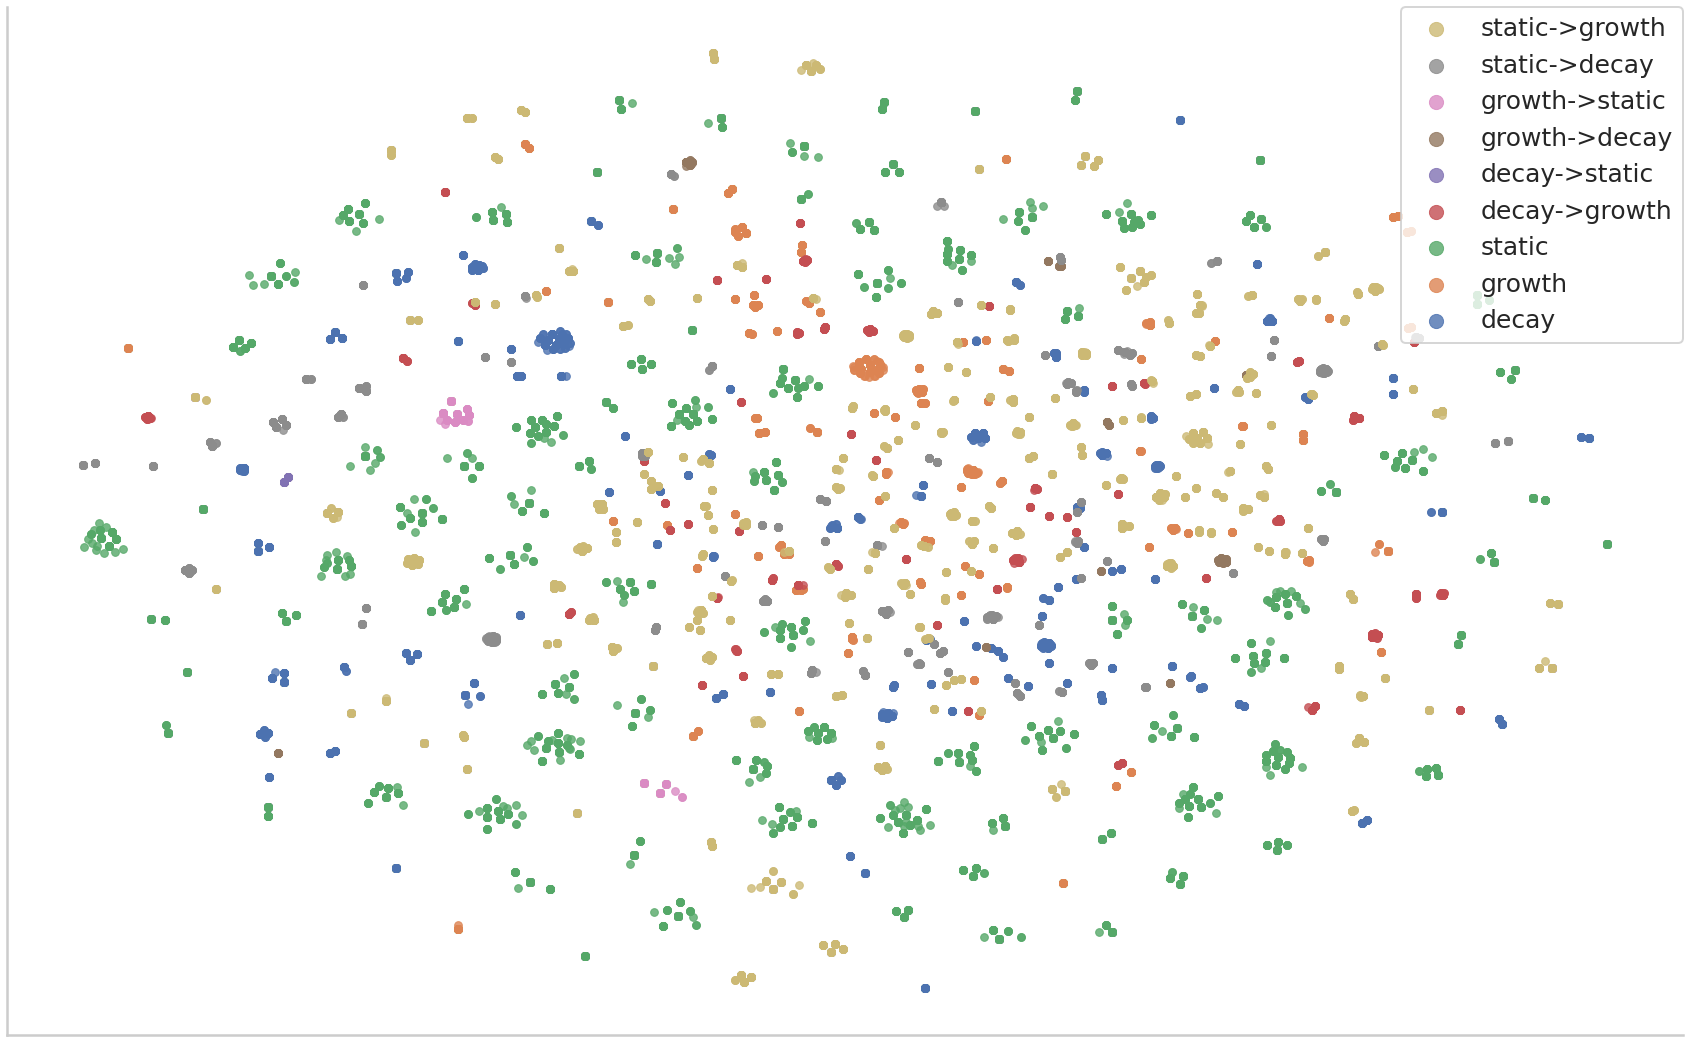

Not saved! The figure /data/yanjun/DeepPhyTree/checkpoints/02172021/split_rs123/models_norm_input2/tsne/org/test_pred.png.png has already existed.


In [52]:
aly_test_tsne = AlyTSNE(feat=x_test.values, label=extend_y_test_pred, subset='test_pred', save_folder=f'{tsne_folder}/org')
aly_test_tsne.generate_tsne(overwrite=False)
aly_test_tsne.plot(legend_info=extend_legend_info)

### XGBoost

===Model for org data===
best validation loss achieved: 0.7864443431495519
Test Acc: 0.7856452651921838
Test Ballance Acc: 0.48235946939420654
Test F1: 0.7316302346038643
One-vs-One ROC AUC scores:
0.832940 (macro),
0.839156 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.832940 (macro),
0.839156 (weighted by prevalence)


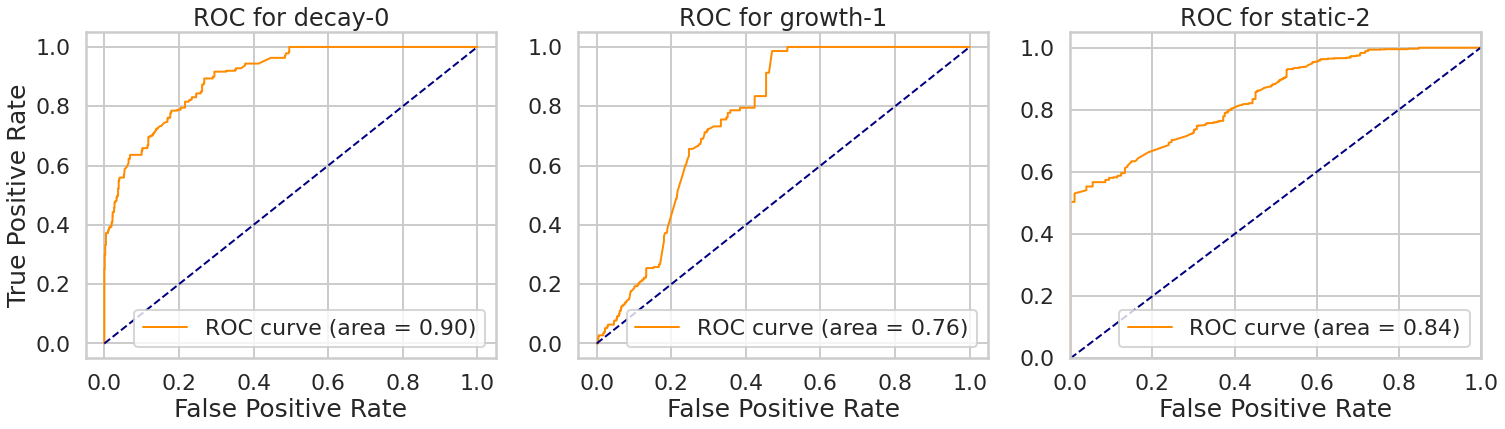



===Model for ros data===
best validation loss achieved: 0.8562612803208062
Test Acc: 0.7096306635172858
Test Ballance Acc: 0.34752244722107156
Test F1: 0.6456187487164633
One-vs-One ROC AUC scores:
0.792539 (macro),
0.814830 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.792539 (macro),
0.814830 (weighted by prevalence)


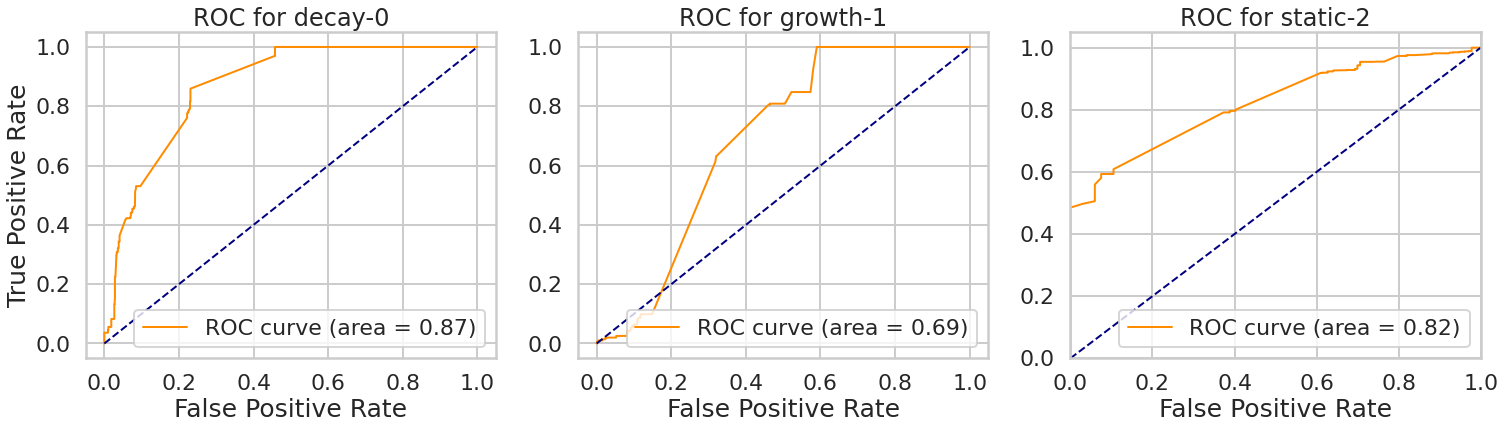



===Model for smotenc data===
best validation loss achieved: 0.5683159878681691
Test Acc: 0.7595018252093623
Test Ballance Acc: 0.5799533180154931
Test F1: 0.7590802925909387
One-vs-One ROC AUC scores:
0.852155 (macro),
0.863139 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.852155 (macro),
0.863139 (weighted by prevalence)


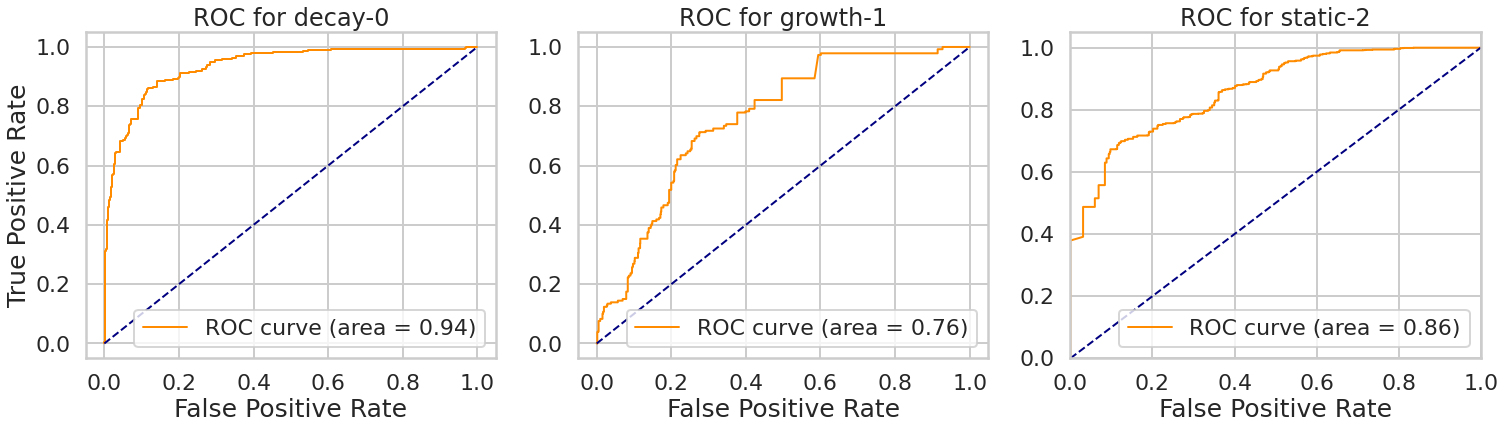

In [53]:
from base_model import XGB

xgb_model_dict = dict()
xgb_metric_dict = defaultdict(list)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    np.random.seed(0)
    print(f"===Model for {sampler_name} data===")
    
    model = XGB()
    best_model = get_best_classifer(model, cv_train, x_train_res, y_train_res, treeid_train, 
                                    x_test, y_test, sfmx_metric_dict)
    xgb_metric_dict['model'].append('rf')
    xgb_metric_dict['sampler_name'].append(sampler_name)
    eval_classifer(best_model, x_test, y_test, xgb_metric_dict)
    xgb_model_dict[sampler_name] = best_model
    print('\n')

[('PD-norm', 0.20635848), ('v_timespan-norm', 0.15895107), ('oster-norm', 0.110258736), ('abs_growth_rate-norm', 0.10927892), ('v_cluster_size-norm', 0.09353693), ('v_sampling_fraction-norm', 0.05785442), ('gamma_cat_2', 0.046112183), ('ltt_shape_cat_0', 0.04341328), ('r_max-norm', 0.039011765), ('birth_rate-norm', 0.03340782), ('fraction_time_growth-norm', 0.029598055), ('cherries-norm', 0.027068652), ('ltt_shape_cat_1', 0.019170202), ('R0-norm', 0.013151072), ('gamma_cat_3', 0.012828419), ('ltt_shape_cat_2', 0.0), ('ltt_shape_cat_3', 0.0), ('gamma_cat_0', 0.0), ('gamma_cat_1', 0.0)]
[('PD-norm', 0.23830944), ('abs_growth_rate-norm', 0.14625348), ('oster-norm', 0.13712561), ('birth_rate-norm', 0.12076824), ('gamma_cat_2', 0.10318055), ('r_max-norm', 0.0869229), ('v_cluster_size-norm', 0.06999723), ('v_timespan-norm', 0.055777106), ('gamma_cat_0', 0.023888627), ('gamma_cat_3', 0.0139959315), ('gamma_cat_1', 0.0014298194), ('ltt_shape_cat_3', 0.00067908835), ('R0-norm', 0.0005981938), (

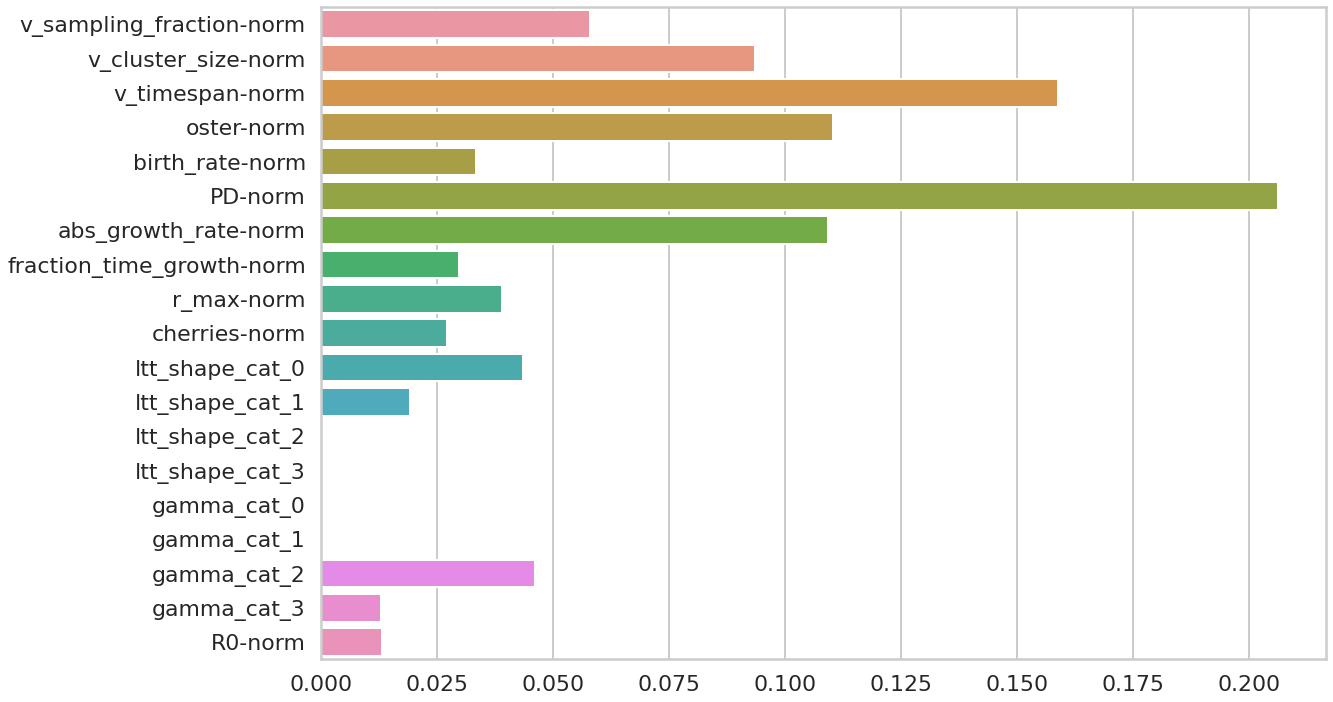

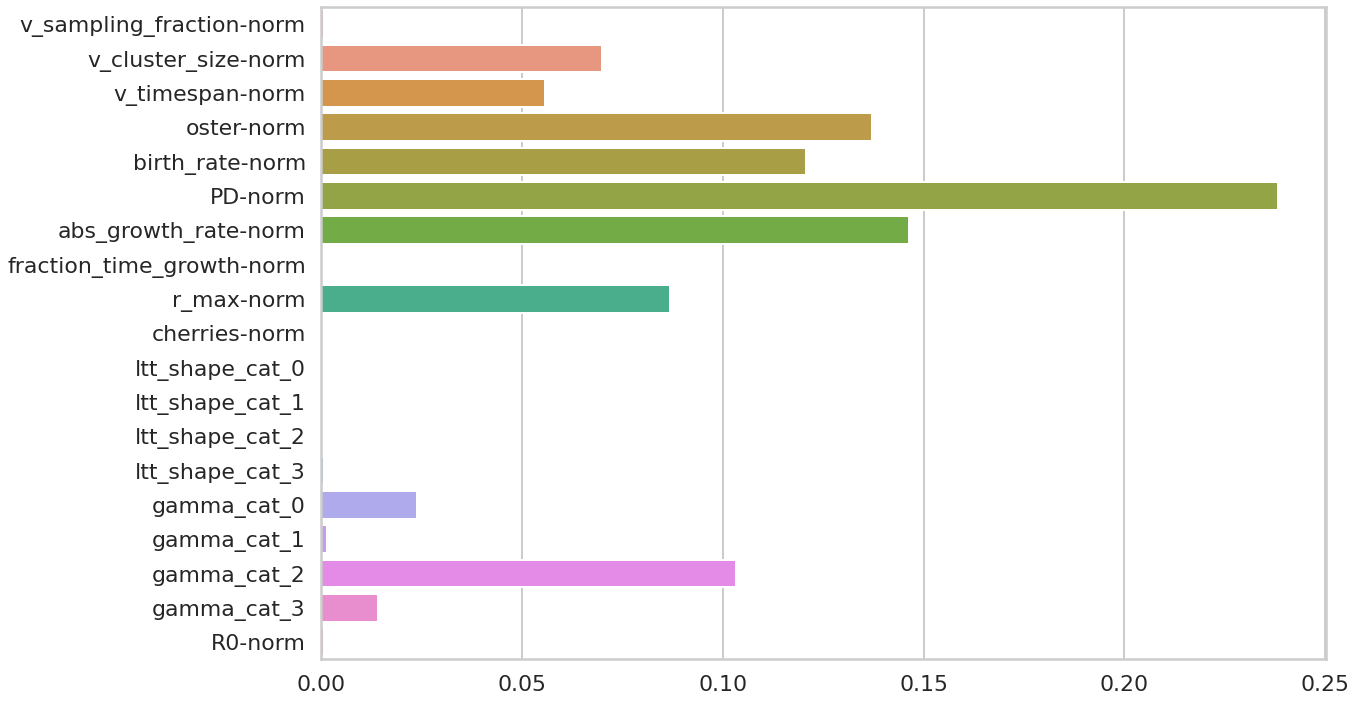

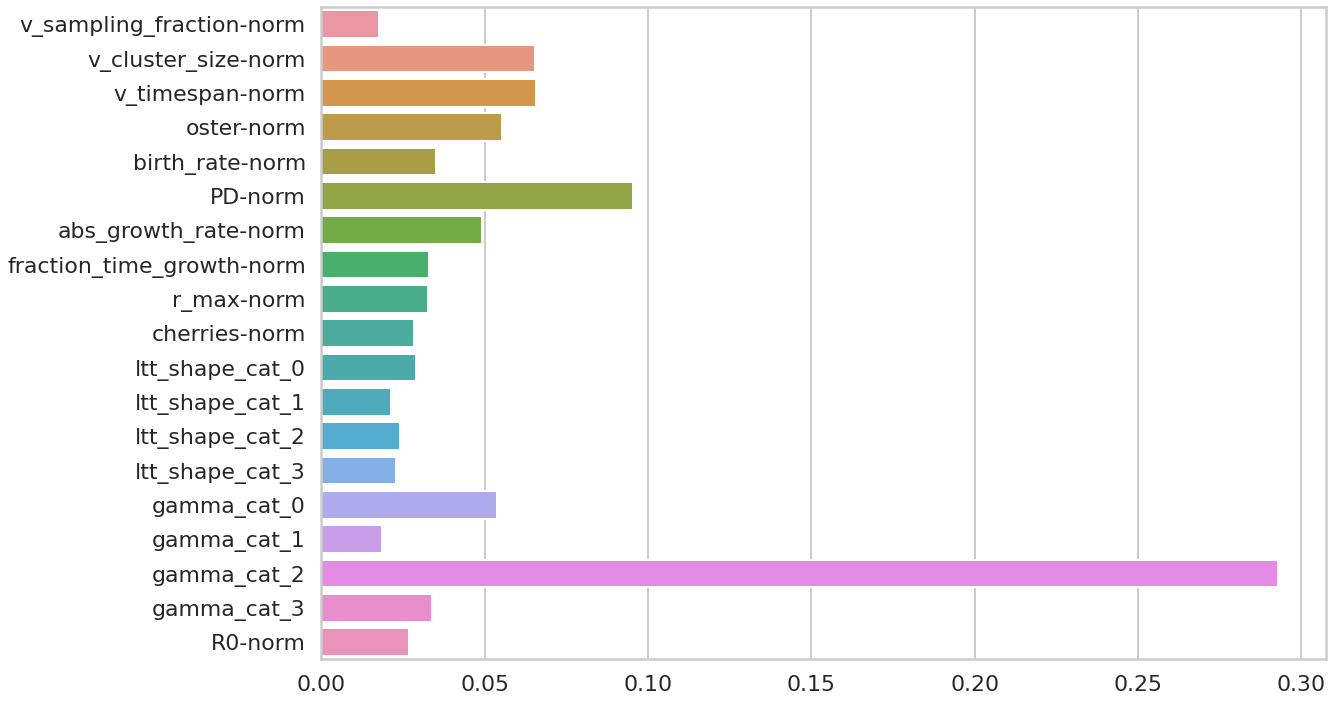

In [54]:
for sampler_type in train_data_dict.keys():
    coef_dict = cal_feat_impt(xgb_model_dict[sampler_type])

In [55]:
from xgboost import plot_importance, plot_tree

def plot_impt(model):
    fig, axs = plt.subplots(2, 1, figsize=(10, 20))

    # Feature importance type: 
    # "gain" is the average gain of splits which use the feature
    # "weight" is the number of times a feature appears in a tree

    for i, impt_type in enumerate(['gain', 'weight']): 
        ax = plot_importance(model, importance_type=impt_type, ax=axs[i], show_values=False)
        ax.set_title(f'Feature importance: {impt_type}')
    plt.show()

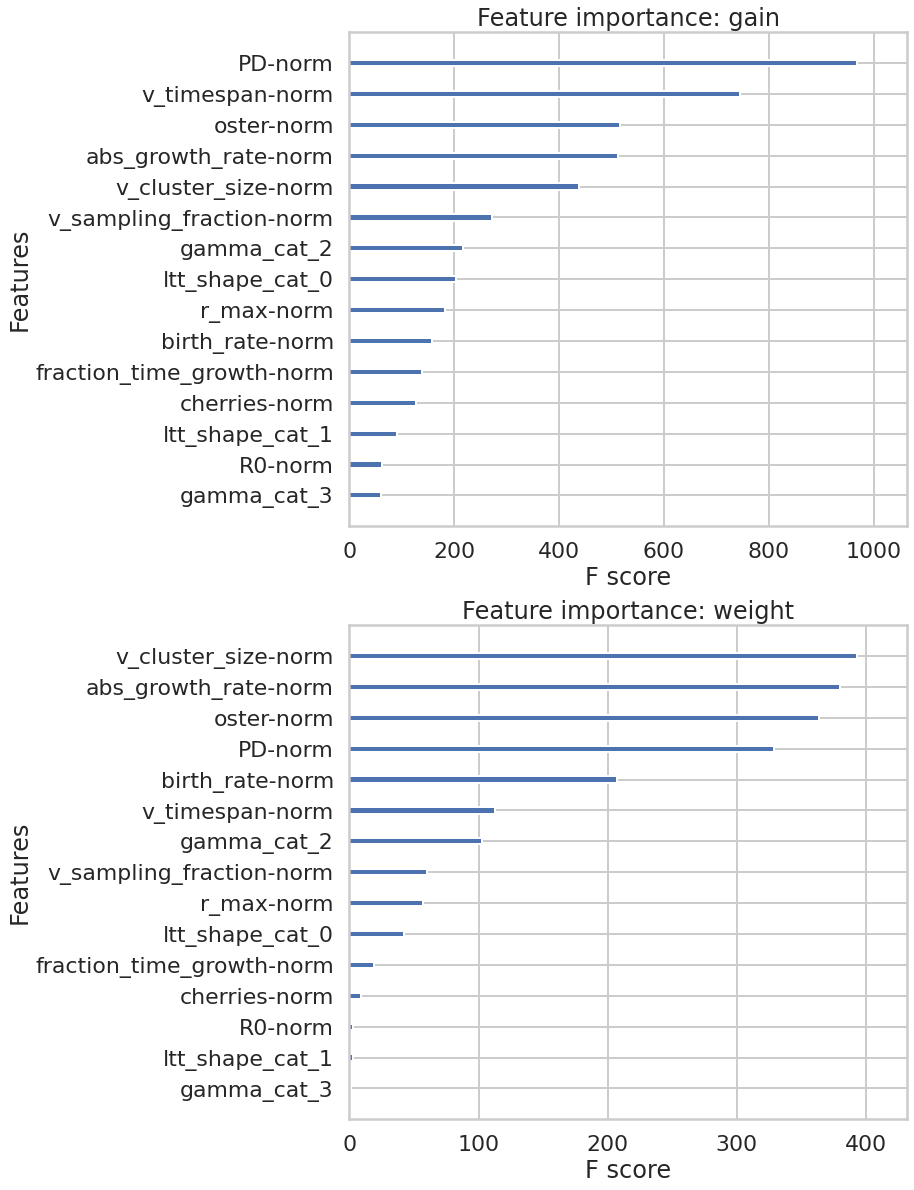

In [56]:
for sampler_type in train_data_dict.keys():
    plot_impt(xgb_model_dict[sampler_type])
    break

In [57]:
save(xgb_metric_dict, 'xgb')